In [1]:
# this documentation makes use of pandas, numpy, and palettable
import pandas as pd
import numpy as np
import palettable
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "arial" # if you don't have arial it will fall back to Deja Vu

# CoMut Documentation

This notebook gives an in depth description of the CoMut package.

You should run all the cells in this notebook before reading the Documentation. Do this by clicking `Run` -> `Run All Cells`

# Table of Contents

1. [Installation](#Installation)
2. [Basic Usage](#Basic_Usage)  
3. [Functions to add data](#add_functions)  
    3.1 [add_categorical_data](#categorical_data)  
    3.2 [add_continuous_data](#continuous_data)  
    3.3 [add_bar_data](#bar_data)  
    3.4 [add_side_bar_data](#side_bar_data)  
    3.5 [add_sample_indicators](#sample_indicators)  
4. [plot_comut](#plot_comut)  
5. [Adding a legend](#legends)  
    5.1 [add_unified_legend](#unified_legend)  
    5.2 [add_axis_legend](#axis_legend)  
6. [Improving comut appearance](#comut_appearance)  
    6.1 [Alter global matplotlib rcParams](#rc_params)  
    6.2 [Editing individual axes](#edit_axes)  
7. [Exporting the comut](#export)  
8. [What to do if you're unfamiliar with Pandas](#pandas_help) 
9. [Example of comut with data from Liu et al. 2019](#example) 
10. [Frequently Asked Questions](#faq)  

<a id="Installation"></a>
# 1. Installation

CoMut can be installed via `pip` with `pip install comut`.

In [ ]:
!pip install comut

Once installed, it can be imported with `from comut import comut`

In [3]:
from comut import comut

CoMut also contains some helper functions for parsing common bioinformatic file types.

In [4]:
from comut import fileparsers

<a id="Basic_Usage"></a>
# 2. Basic Usage

Making CoMut plots using this package revolves around the `CoMut` object. A CoMut object is instantiated with `comut.CoMut()`. This will always be the first step in building a comut.

In [5]:
toy_comut = comut.CoMut()

A CoMut object has 3 attributes that users manage to make comut plots. They are as follows:

1. `comut.samples`: A list of samples. This specifies the order of the CoMut's samples (from left to right) as columns in the comut.
2. `comut.axes`: A dictionary that contains the [axis objects](https://matplotlib.org/api/axes_api.html) after the comut is plotted. Not created until `comut.plot_comut()` is called.
3. `comut.figure`: The [figure](https://matplotlib.org/api/figure_api.html) on which the comut is created. Not created until `comut.plot_comut()` is called.

CoMut takes in [tidy](https://vita.had.co.nz/papers/tidy-data.pdf) [pandas](https://pandas.pydata.org/docs/) dataframes as data, though the exact form depends on what type of data you're adding (see [Functions to Add Data](#add_functions)). If you're unfamiliar with pandas, see the section [What to do if you're unfamiliar with pandas](#pandas_help)

In [6]:
# example categorical data
data = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
data.head(2)

,sample,category,value
0,Sample2,BRCA2,Splice site
1,Sample2,NRAS,Frameshift indel


Data is added to the CoMut object with `add_xxx_data` functions. Data is added to the CoMut object from the __bottom -> up__, which means that the first dataset added to the CoMut object will be the lowest in the comut. The comut can then be plotted with `comut.plot_comut()`

<bound method CoMut.add_unified_legend of <comut.comut.CoMut object at 0x11aa41f60>>

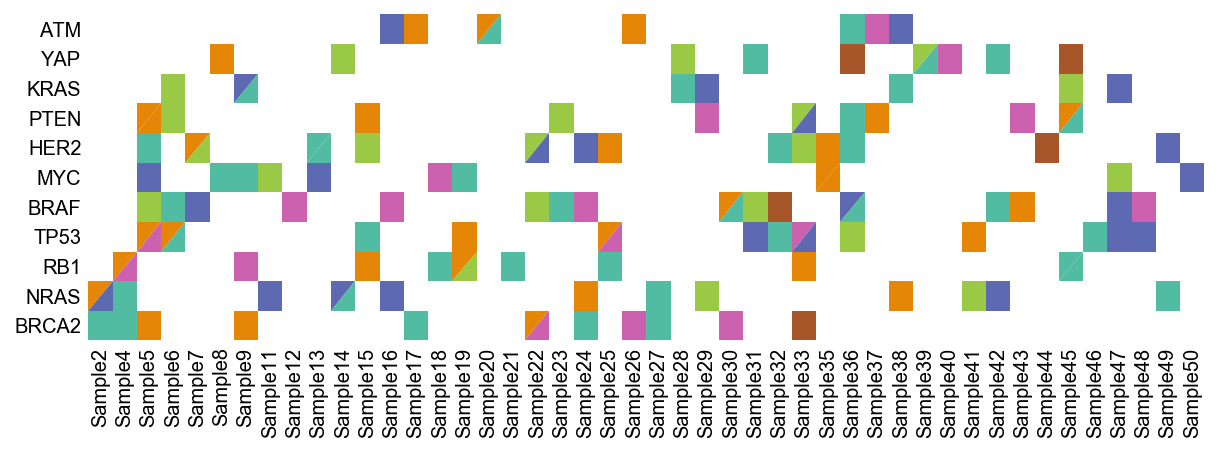

In [7]:
toy_comut = comut.CoMut()
toy_comut.add_categorical_data(data, name = 'Mutation type')
toy_comut.plot_comut(figsize = (10,3))
toy_comut.add_unified_legend

<a id="add_functions"></a>
# 3. Functions to add data

CoMut currently supports 5 types of data:

1. [Categorical data](#categorical_data): Data that has categories and discrete values. The central portion of the comut, mutation data, is categorical. Clinical variables like biopsy site, stage, etc are also categorical.

2. [Continuous data](#continuous_data): Data that has a category but continuous values. A common example is tumour purity.

3. [Bar graphs](#bar_data): Data that applies to each sample and is usually continuous. Common examples include mutation burden or mutational signatures.

4. [Side bar graphs](#side_bar_data): Data that applies to categories in one of the categorical plots. Common examples include the number of samples mutated in a gene or a q-value from MutSig.

5. [Sample indicators](#sample_indicators): Data that shows how samples are related. For example, this can be used to indicate samples from the same patient.

Here is an example of a comut with the data types labelled:

<img src="tutorial_data/data_types.png">

<a id="categorical_data"></a>
## 3.1 `add_categorical_data`

This function adds categorical data to the comut. Categorical data has three required columns - `sample`, `category`, and `value`. Other columns are ignored. Samples with more than three values for a category are colored as `Multiple` (default brown). Samples with `Not Available` are drawn as boxes with a slash through them.

__Arguments__

* `data` - The data being added to the comut, in the form of a tidy pandas dataframe. Required columns are `sample`, `category`, and `value`.

* `name` - The name of the plot being added to the comut, as a string. If not given, it will default to the integer number of plots currently in the plot - 1.

* `category_order` - A list that sets the order that categories appear, from bottom to top. Defaults to all unique categories present in data in the order they appear in the data. A subset of the categories can be given to only plot those categories.

* `value_order` - A list that sets the order of values within a single patch in the comut. Defaults to an alphabetical ordering of all unique values in the data.

* `mapping` - a dictionary that maps values to colors. The dictionary keys should be the data values (eg 'Missense'), with dictionary values as either a valid [color option](https://matplotlib.org/3.1.1/api/colors_api.html) or [patches_kwargs](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Patch.html). Note that three additional values are required to fully specify mapping:

    *  `Absent`, which determines the color for samples without value in a category (default white)
    * `Multiple`, which determines the color for samples with more than two values in that category (default brown).
    * `Not Available`, which determines the patch properties when data is unavailable.  


* `borders` - A list that allows you to set certain values as a border for a patch.

* `priority` - A list that gives priority to certain values, subverting the "Multiple" classification. 

* `tick_style` - A string that controls how the yticklabels appear. Allowed values are `'normal'`, `'italic'`, `'oblique'`. Defaults to `'normal'`

__Example__:

In [8]:
# import data, add LOH to some of the PTEN mutations, make a missing TP53 for Sample2
data = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
extra_data = pd.DataFrame({'sample': ['Sample15', 'Sample37', 'Sample2'], 'category': ['PTEN', 'PTEN', 'TP53'], 
                         'value': ['LOH', 'LOH', 'Not Available']})
data = pd.concat([data, extra_data])
data.tail(5)

,sample,category,value
147,Sample49,NRAS,Splice site
148,Sample50,MYC,Nonsense
0,Sample15,PTEN,LOH
1,Sample37,PTEN,LOH
2,Sample2,TP53,Not Available


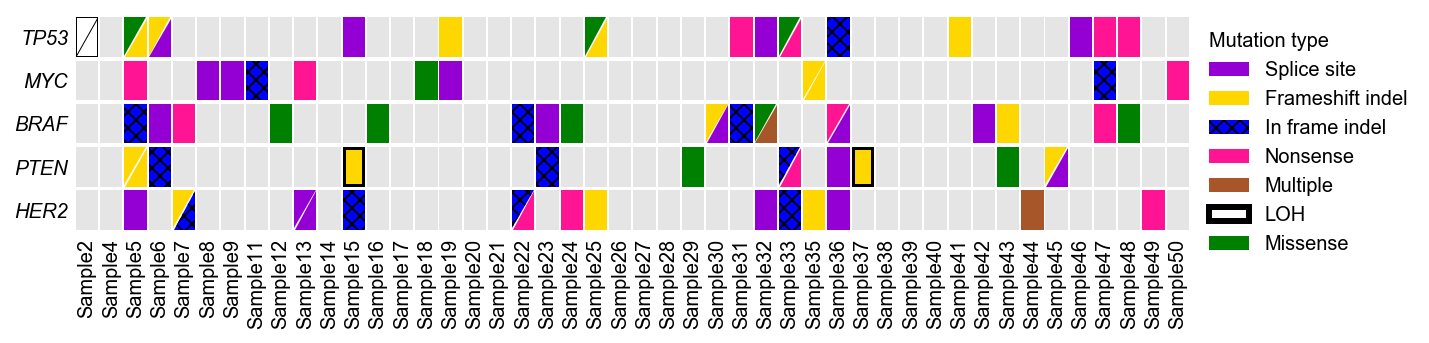

In [9]:
# specify color map - make absent a light grey, use hatching for in frame indel, make LOH a border
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
mut_mapping = {'Missense': 'green', 'Nonsense': 'deeppink', 'In frame indel': {'facecolor': 'blue', 'hatch': 'xxx'},
               'Frameshift indel':'#FFD700', 'Splice site': 'darkviolet', 'LOH': {'facecolor':'none', 'edgecolor':'black', 'linewidth': 3},
               'Absent': {'facecolor': 'grey', 'alpha': 0.2}}

# define category order - only plot these categories
category_order = ['HER2', 'PTEN', 'BRAF', 'MYC', 'TP53']

# make Missense always be the upper left triangle if present with another mutation
value_order = ['Missense']

# make LOH a border
borders = ['LOH']

# give priority to Missense - if three mutations are present, Missense + Multiple will be shown rather than Multiple
priority = ['Missense']

toy_comut = comut.CoMut()
toy_comut.add_categorical_data(data, name = 'Mutation type', mapping = mut_mapping, category_order = category_order,
                               value_order = value_order, borders = borders, tick_style = 'italic', priority = priority)
toy_comut.plot_comut(figsize = (10, 2), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03)
toy_comut.add_unified_legend()

Note that sample2 is shown as a box with a slash, while PTEN has some samples with LOH given as a border. Sample32 has three mutations in BRAF, but because Missense was given priority, it is shown as Missense + Multiple.

<a id="continuous_data"></a>
## 3.2 `add_continuous_data`

This function adds continuous data to the comut. Continuous data has three required columns - `sample`, `category`, and `value`. Other columns are ignored.

__Note:__ As of the current release, only one category is allowed for continuous data. Different categories should be added separately.

__Arguments__

* `data` - The data being added to the comut, in the form of a tidy pandas dataframe. Required columns are `sample`, `category`, and `value`. `value` can be a combination of continuous data (specified with `mapping`) and categorical data (specified by `cat_mapping`)

* `name` - The name of the plot being added to the comut, as a string. If not given, it will default to the integer number of plots currently in the plot - 1.

* `value_range` - The range of the data. Used to calculate the color based on the color map. Defaults to the range of the data.

* `mapping` - A mapping of continuous value to color. Can be defined as matplotlib colormap (str) or a custom LinearSegmentedColormap. Defaults to `binary`. Samples that are missing in the dataframe are colored according to the `Absent` key in `cat_mapping` (so default white)

* `cat_mapping` - Mapping from a discrete category to patch color. Primarily used to override defaults for `Absent` and `Not Available` but can be used to mix categorical and continuous values in the same data.

* `tick_style` - A string that controls how the yticklabels. Allowed values are `normal`, `italic`, `oblique`. Defaults to `normal`

__Example__:

In [10]:
# import categorical data and continuous data (purity)
cat_data = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
purity_data = pd.read_csv('tutorial_data/tutorial_purity.tsv', sep = '\t')
purity_data.head(2)

,sample,category,value
0,Sample1,Purity,0.49
1,Sample2,Purity,0.39


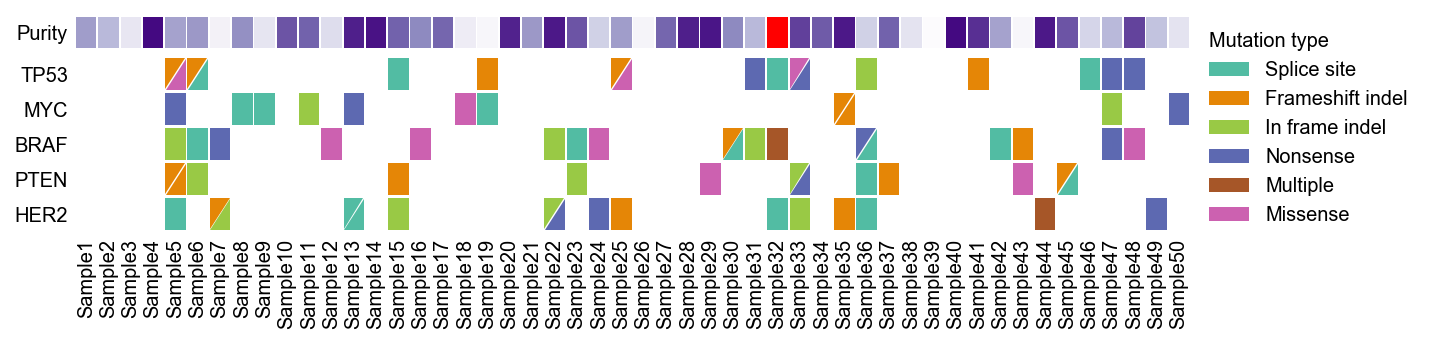

In [11]:
# drop Sample32 to demonstrate Absent and specify Absent mapping
purity_data = purity_data.drop(purity_data[purity_data['sample'] == 'Sample32'].index)
cat_mapping = {'Absent': {'facecolor': 'red'}}

# Purity can be 0 - 1
value_range = (0, 1)

# create comut object and categorical data
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]
toy_comut.add_categorical_data(cat_data, name = 'Mutation type', category_order = ['HER2', 'PTEN', 'BRAF', 'MYC', 'TP53'])

# add continuous data
toy_comut.add_continuous_data(purity_data, name = 'Purity', mapping = 'Purples', cat_mapping = cat_mapping, value_range = value_range)

toy_comut.plot_comut(figsize = (10, 2), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, hspace = 0.05)
toy_comut.add_unified_legend()

We can see that because Sample32 was removed from the dataframe, it was colored according to `Absent` (which we changed to red from its default white). 

<a id="bar_data"></a>
## 3.3 `add_bar_data`

This function adds a bar graph to the comut. The bar graph can be stacked (multiple categories) or unstacked (one category).

__Note__: Bar graphs go in the central comut. Bar graphs added to the side of the comut are side bar graphs - see [Adding Side Bar Data](#side_bar_data) for details. 

__Arguments__

* `data` - The bar data being added to the comut, in the form of a tidy pandas dataframe. The first column must be named `sample`, with other columns being the categories and values of the data.

* `name` - The name of the plot being added to the comut, as a string. Defaults to the integer number of plots currently in the plot - 1.

* `stacked` - Whether or not the bar graph should be stacked. If `False`, the second column is used as the data and others are ignored. Defaults to `False`.

* `mapping` - A mapping of column to color. Dictionary should map column name to color as a valid matplotlib [color option](https://matplotlib.org/3.1.1/api/colors_api.html) __not__ patches_kwargs.

* `ylabel` - A string with which to label the y axis. Defaults to an empty string

* `bar_kwargs` - A dictionary of kwargs to pass to plt.bar during the process of plotting. See [here](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.bar.html) for a full description of possible arguments. Important arguments include `width` (which is by default 1 - 2*`x_padding` to match categorical data) and `edgecolor`.

__Example__:

In [12]:
# import categorical data and continuous data
cat_data = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
purity_data = pd.read_csv('tutorial_data/tutorial_purity.tsv', sep = '\t')

# import bar data
mut_burden_df = pd.read_csv('tutorial_data/tutorial_mutation_burden.tsv', sep = '\t')
mut_burden_df.head(3)

,sample,Nonsynonymous,Synonymous
0,Sample1,62,1
1,Sample2,67,26
2,Sample3,15,5


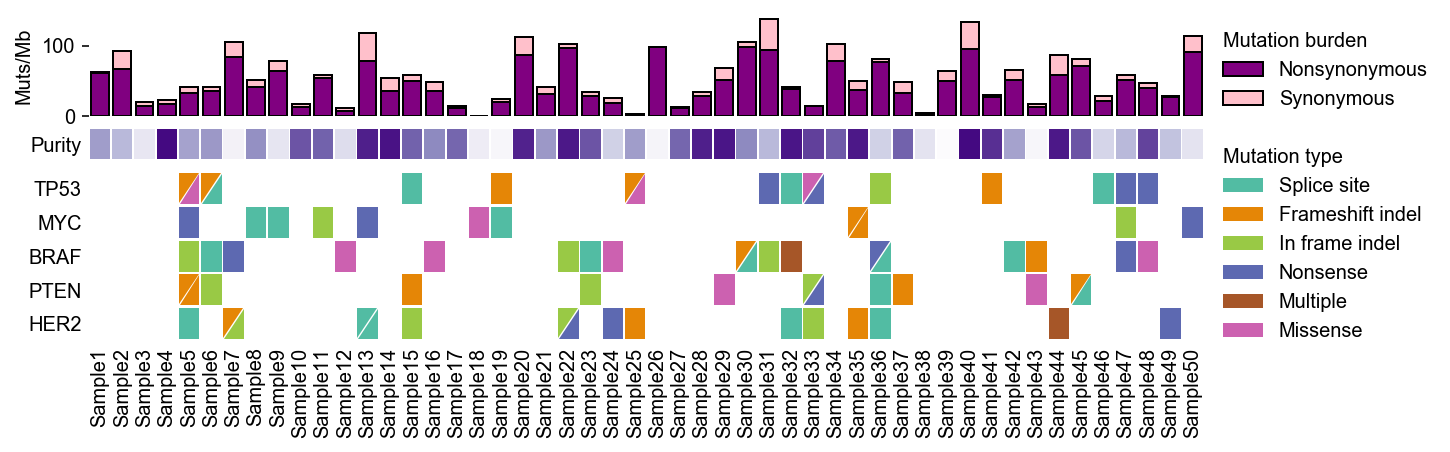

In [13]:
# define mapping, shrink
bar_mapping = {'Nonsynonymous': 'purple', 'Synonymous': 'pink'}
bar_kwargs = {'width': 0.8, 'edgecolor': 'black'}

# create comut object and add categorical and continuous data
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]
toy_comut.add_categorical_data(cat_data, name = 'Mutation type', category_order = ['HER2', 'PTEN', 'BRAF', 'MYC', 'TP53'])
toy_comut.add_continuous_data(purity_data, name = 'Purity', mapping = 'Purples', value_range = (0, 1))

# add bar data
toy_comut.add_bar_data(mut_burden_df, name = 'Mutation burden', mapping = bar_mapping, stacked = True, bar_kwargs = bar_kwargs, 
                       ylabel = 'Muts/Mb')

toy_comut.plot_comut(figsize = (10, 3), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, hspace = 0.1)
toy_comut.add_unified_legend()

<a id = "side_bar_data"></a>
## 3.4 `add_side_bar_data`

This function adds a side bar graph to the comut, which are __category__ level data. The bar graph can be stacked (multiple categories) or unstacked (one category).

__Note:__ By default, the y-axis for side bar graphs (the part parallel to the comut) is invisible. This can be changed by editing the axis object after plotting (see the [melanoma example](#mel_axes))

__Arguments__:

* `data` - The bar data being added, in the form of a tidy pandas dataframe. There is one required column: `category`. Other columns will be interpreted as data for the side bar graph.

* `paired_name` - The name of the categorical plot with which the side bar graph is paired. Side bar plots are required to be paired with a categorical plot.

* `name` - The name of the side plot being added to the comut, as a string. If not given, it will default to the integer number of plots currently in the plot - 1.

* `position` - The position of the side bar data (either `'right'` or `'left'`, defaults to `'right'`).

* `stacked` - Whether or not the bar graph should be stacked. If `False`, the second column is used as the data and others are ignored. Defaults to `False`.

* `mapping` - A mapping of column to color. Dictionary should map column name to color as a valid matplotlib [color option](https://matplotlib.org/3.1.1/api/colors_api.html).

* `xlabel` - A string with which to label the x axis. Defaults to an empty string.

* `bar_kwargs` - A dictionary of kwargs to pass to plt.barh during the process of plotting. See [here](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.barh.html) for a full description of possible arguments. Important arguments include `height` (which defaults to 1 - 2*`y_padding` to match categorical data) and `edgecolor`. 

__Example__:

In [14]:
# import other data
cat_data = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
purity_data = pd.read_csv('tutorial_data/tutorial_purity.tsv', sep = '\t')
mut_burden_df = pd.read_csv('tutorial_data/tutorial_mutation_burden.tsv', sep = '\t')

# import side bar data
mutsig_df = pd.read_csv('tutorial_data/tutorial_mutsig_qvals.tsv', sep = '\t')
mutsig_df.head()

,category,-log(Q)
0,BRCA2,0.1
1,NRAS,0.3
2,RB1,0.5
3,TP53,0.8
4,BRAF,1.2


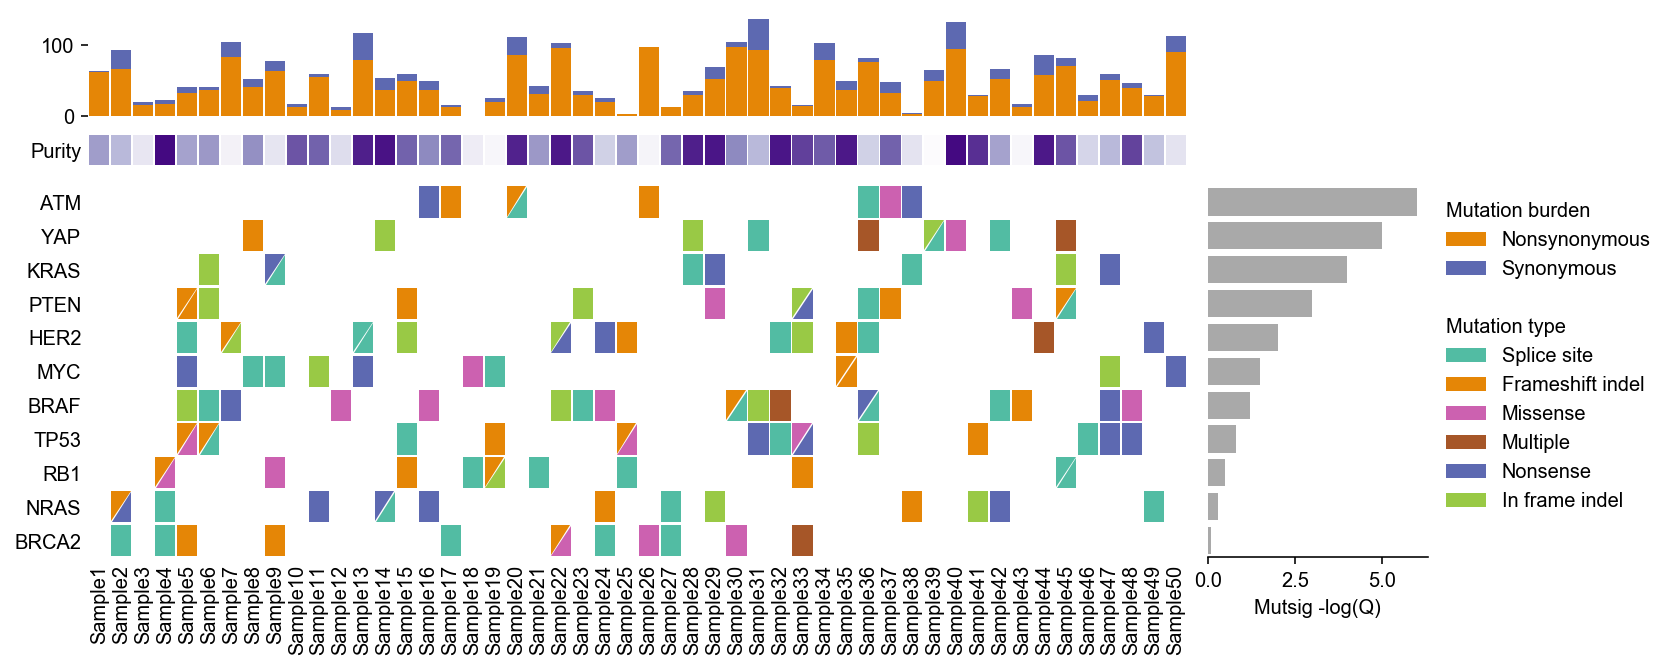

In [15]:
# make CoMut
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]

toy_comut.add_categorical_data(cat_data, name = 'Mutation type')
toy_comut.add_continuous_data(purity_data, name = 'Purity', mapping = 'Purples', value_range = (0, 1))
toy_comut.add_bar_data(mut_burden_df, stacked = True, name = 'Mutation burden')

# create mapping for side bar data, make the bars thinner with bar_kwargs
side_mapping = {'-log(Q)': 'darkgrey'}
bar_kwargs = {'height': 0.8}
toy_comut.add_side_bar_data(mutsig_df, paired_name = 'Mutation type', name = 'Mutsig',
                            mapping = side_mapping, xlabel = 'Mutsig -log(Q)', position = 'right', bar_kwargs = bar_kwargs)

toy_comut.plot_comut(figsize = (12, 5), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, hspace = 0.1, wspace = 0.03)
toy_comut.add_unified_legend(axis_name = 'Mutsig')

<a id="sample_indicators"></a>
## 3.5 `add_sample_indicators`

This function adds sample indicators to the comut, which are small plots that indicate the relationship between two samples (for example, if they're from the same patient)

__Note:__ `add_sample_indicators` will throw an error if samples with the same group value are not adjacent in the sample order of the comut.

__Arguments__

* `data` - A tidy pandas dataframe that assigns individual samples to groups. The value of the groups does not matter as long as samples in the same group have the same value. Required columns are 'sample' and 'group'. Other columns are ignored.

* `name` - The name of the plot being added to the comut, as a string. If not given, it will default to the integer number of plots currently in the plot - 1.

* `plot_kwargs` - A dictionary of kwargs to pass to plt.plot during the process of plotting. See [here](https://matplotlib.org/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D) for a full description of possible arguments. The default for this parameter is `{'color': 'black', 'marker': 'o', markersize': 3}`, meaning black circles are used.

__Example__:

In [16]:
# import other data
cat_data = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
purity_data = pd.read_csv('tutorial_data/tutorial_purity.tsv', sep = '\t')
mut_burden_df = pd.read_csv('tutorial_data/tutorial_mutation_burden.tsv', sep = '\t')
mutsig_df = pd.read_csv('tutorial_data/tutorial_mutsig_qvals.tsv', sep = '\t')

# import indicator data
indicator_df = pd.read_csv('tutorial_data/tutorial_indicator.tsv', sep = '\t')
indicator_df.head()

,sample,group
0,Sample1,0
1,Sample2,0
2,Sample3,1
3,Sample4,1
4,Sample5,1


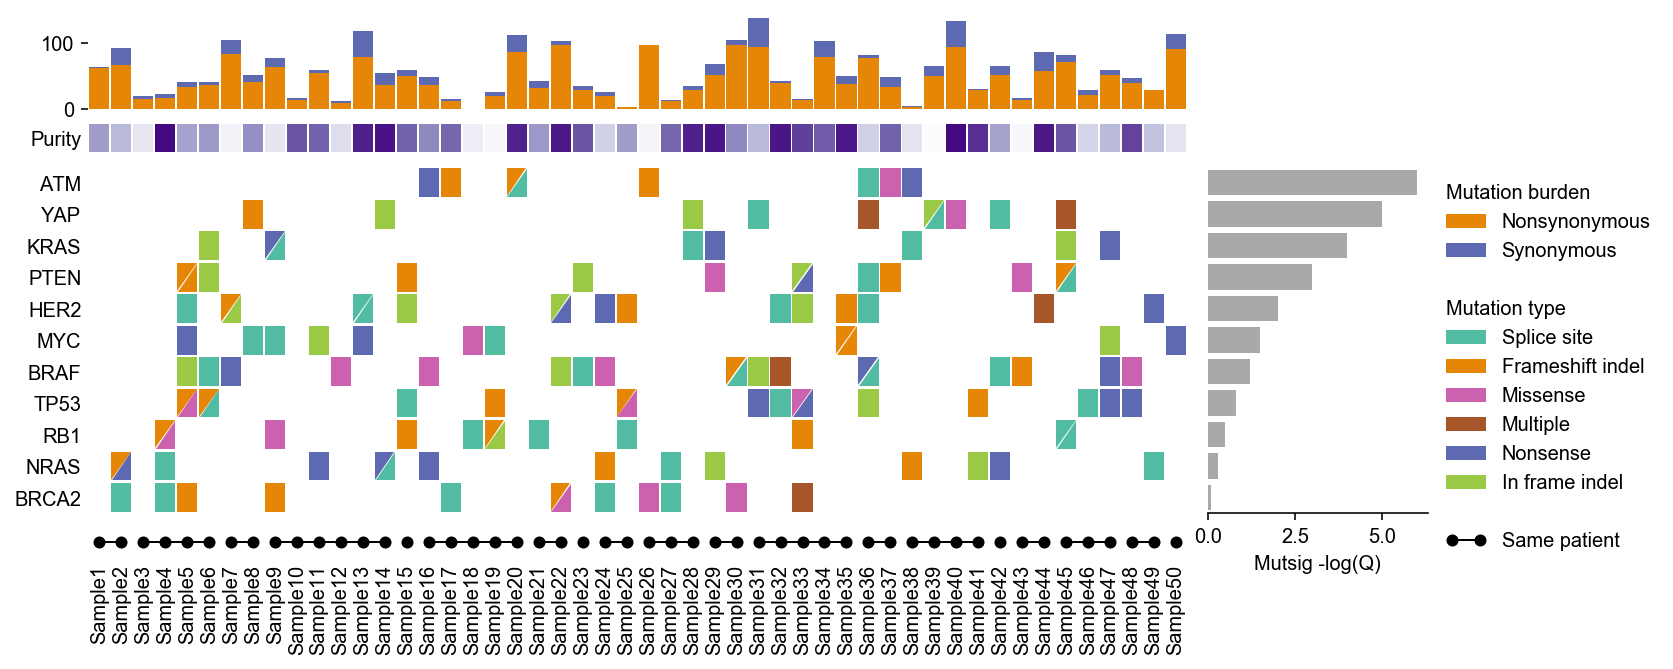

In [17]:
# make CoMut
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]

# add indicators first, since they will be at the bottom
indicator_kwargs = {'color': 'black', 'marker': 'o', 'linewidth': 1, 'markersize': 5}
toy_comut.add_sample_indicators(indicator_df, name = 'Same patient', plot_kwargs = indicator_kwargs)

# add other data
toy_comut.add_categorical_data(cat_data, name = 'Mutation type')
toy_comut.add_continuous_data(purity_data, name = 'Purity', mapping = 'Purples', value_range = (0, 1))
toy_comut.add_bar_data(mut_burden_df, stacked = True, name = 'Mutation burden')
toy_comut.add_side_bar_data(mutsig_df, paired_name = 'Mutation type', name = 'Mutsig',
                            mapping = {'-log(Q)': 'darkgrey'}, xlabel = 'Mutsig -log(Q)', position = 'right', bar_kwargs = bar_kwargs)

# plot comut
toy_comut.plot_comut(figsize = (12, 5), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, hspace = 0.1, wspace = 0.03)

# since plot is to the right, default axis_name is insufficient. Needs to be the right bar plot
toy_comut.add_unified_legend(axis_name = 'Mutsig', numpoints = 2)

<a id="plot_comut"></a>
# 4. `plot_comut`

__Arguments__

* `x_padding`, `y_padding`: float, sets the distance between patches. Defaults to 0.

* `tri_padding`: float, sets the distance between triangles in a patch. Defaults to 0.

* `hspace`: float, sets the distance between different plots in the comut. Defaults to 0.2

* `wspace`: float, sets the distance between side bar plots and the central comut. Default 0.2

* `heights`: dictionary that sets the __relative__ heights of the plots in the comut. Dictionary keys should be the plot name and dictionary values should be the relative height. Defaults to the following:

   * Number of categories for categorical data (ex: if mutation data has 11 genes, its relative height is 11)
   * 1 for continuous data 
   * 3 for bar plots  
   * 1 for sample indicators   


* `widths`: a list that controls the __relative__ widths of the sideplots in the comut vs. the main figure. It defaults to 1 for side plots and 5 for the main comut.

* `structure`: A list of lists that is used to control the structure of the comut. Can be used to plot a subset of plots, reorder plots, and combine plots into one subplot (decreasing the distance between them). 

* `subplot_hspace`: float, distance between plots defined as a subplot (within the same list in `structure`)

* `figsize`: A two element tuple that controls the size of the comut figure. Can be used to alter the shape of patches. Defaults to the matplotlib rcParams default, usually (6.4, 4.8) unless changed.

* `fig`: A figure to place the comut in. If no figure is passed, one will be created.

* `spec`: For advanced users, CoMut will place the comut plot within a spec of a gridspec if defined.

__Example__:

In [18]:
# import all data
mut_df = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
purity_df = pd.read_csv('tutorial_data/tutorial_purity.tsv', sep = '\t')
biopsy_df = pd.read_csv('tutorial_data/tutorial_biopsy_site.tsv', sep = '\t')
mut_burden_df = pd.read_csv('tutorial_data/tutorial_mutation_burden.tsv', sep = '\t')
mutsig_df = pd.read_csv('tutorial_data/tutorial_mutsig_qvals.tsv', sep = '\t')

In [19]:
# make CoMut
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]

# add other data
toy_comut.add_categorical_data(cat_data, name = 'Mutation type')
toy_comut.add_continuous_data(purity_data, name = 'Purity', mapping = 'Purples', value_range = (0, 1))
toy_comut.add_categorical_data(biopsy_df, name = 'Biopsy site')
toy_comut.add_bar_data(mut_burden_df, stacked = True, name = 'Mutation burden')
toy_comut.add_side_bar_data(mutsig_df, paired_name = 'Mutation type', name = 'Mutsig',
                            mapping = {'-log(Q)': 'darkgrey'}, xlabel = 'Mutsig -log(Q)', position = 'right')

Plot the comut with `plot_comut` and only padding parameters:

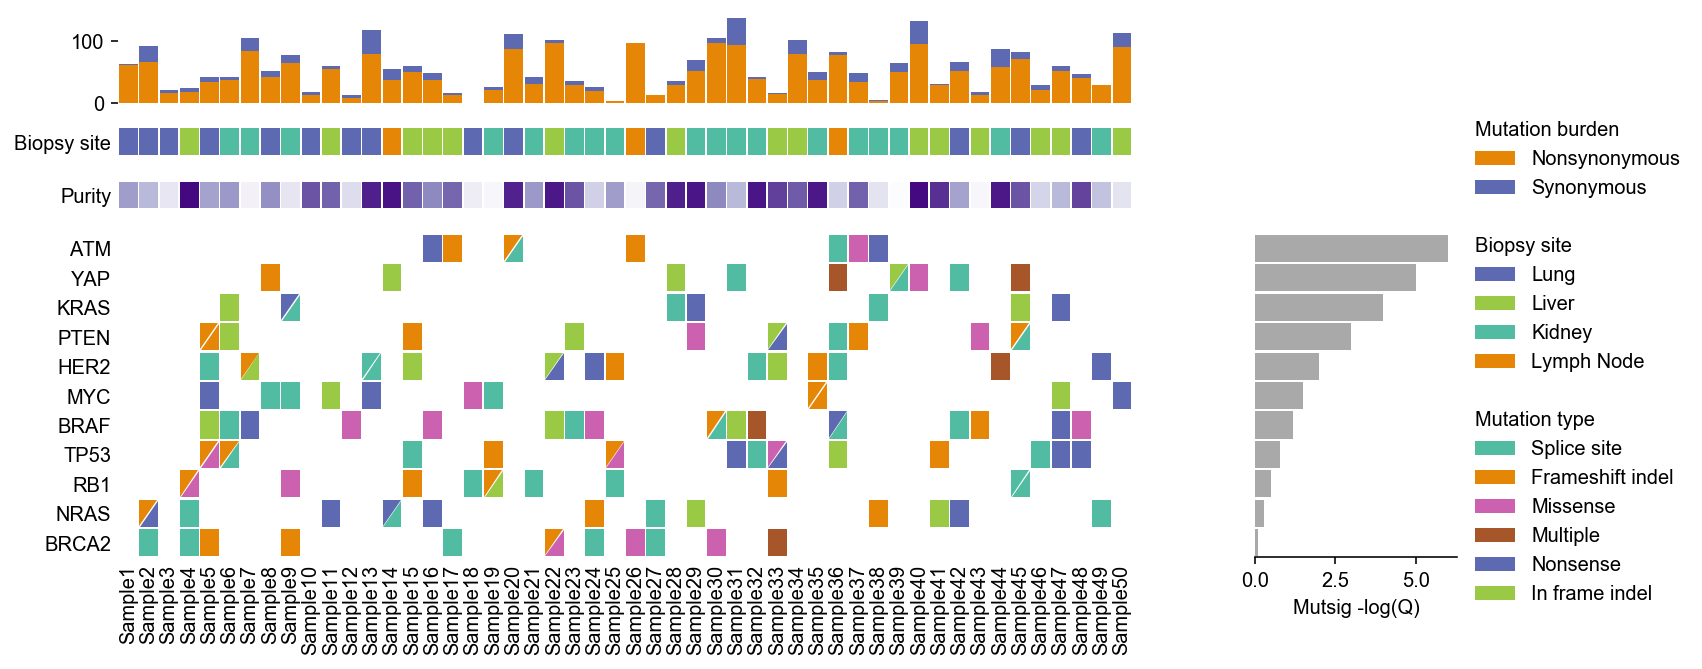

In [20]:
toy_comut.plot_comut(figsize = (12, 5), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03)
toy_comut.add_unified_legend(axis_name = 'Mutsig', bbox_to_anchor = (1, 1.4), numpoints = 2)

Plot the comut with `plot_comut` and additional parameters

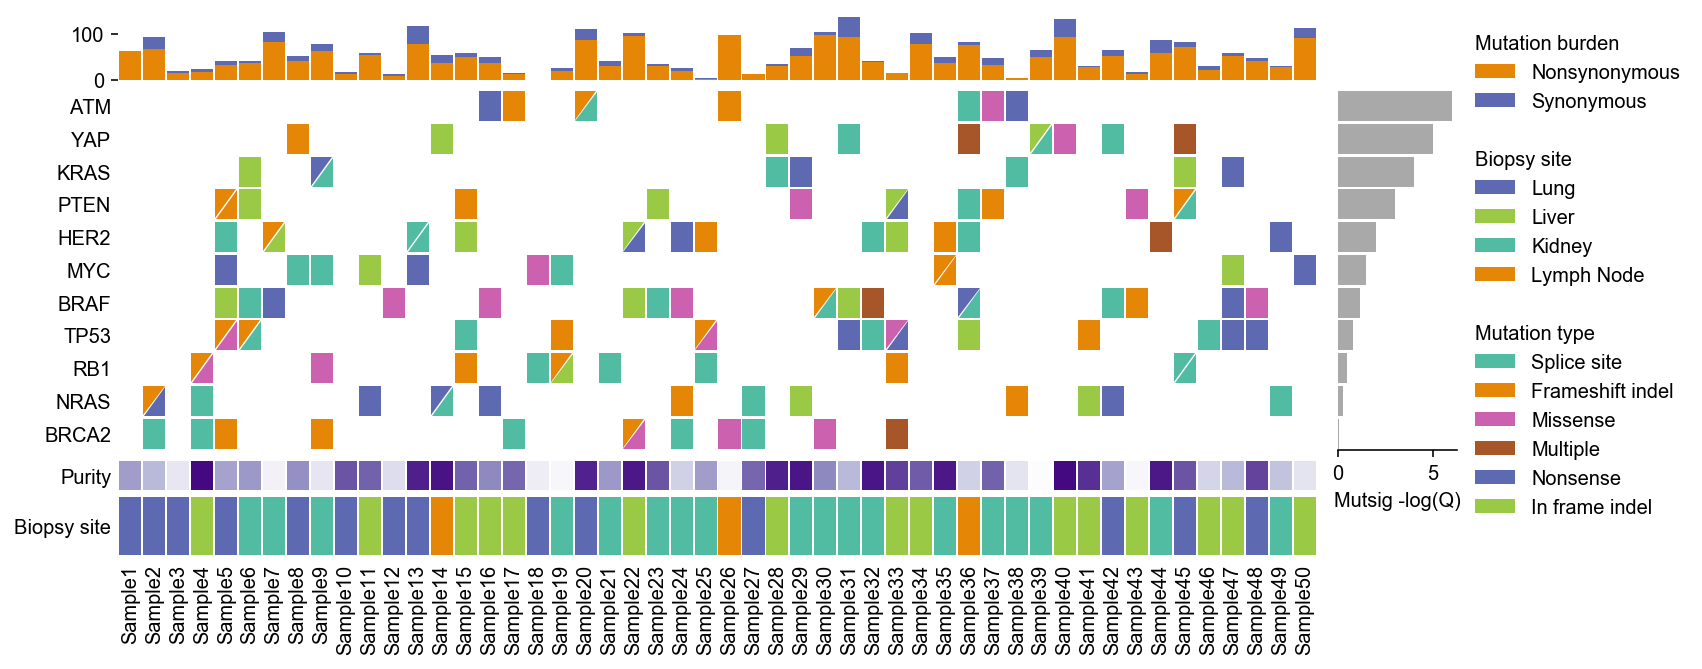

In [21]:
# decrease space between plots with space and wspace
hspace = 0.05
wspace = 0.03

# increase height of biopsy site from default 1 and decrease burden height from default 3
heights = {'Biopsy site': 2, 'Mutation burden': 2}

# decrease size given to side bar plot
widths = [5, 0.5]

# move biopsy and purity together and below mutations
structure = [['Biopsy site', 'Purity'], ['Mutation type'], ['Mutation burden']]

# decrease distance between purity and biopsy site
subplot_hspace = 0.02

# plot with new parameters
toy_comut.plot_comut(figsize = (12, 5), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, hspace = hspace, wspace = wspace,
                     heights = heights, widths = widths, structure = structure, subplot_hspace = subplot_hspace)
toy_comut.add_unified_legend(axis_name = 'Mutsig', bbox_to_anchor = (1, 1.2))

We can also put this plot within a figure and spec:

Text(0.35, 0.5, 'Different plot')

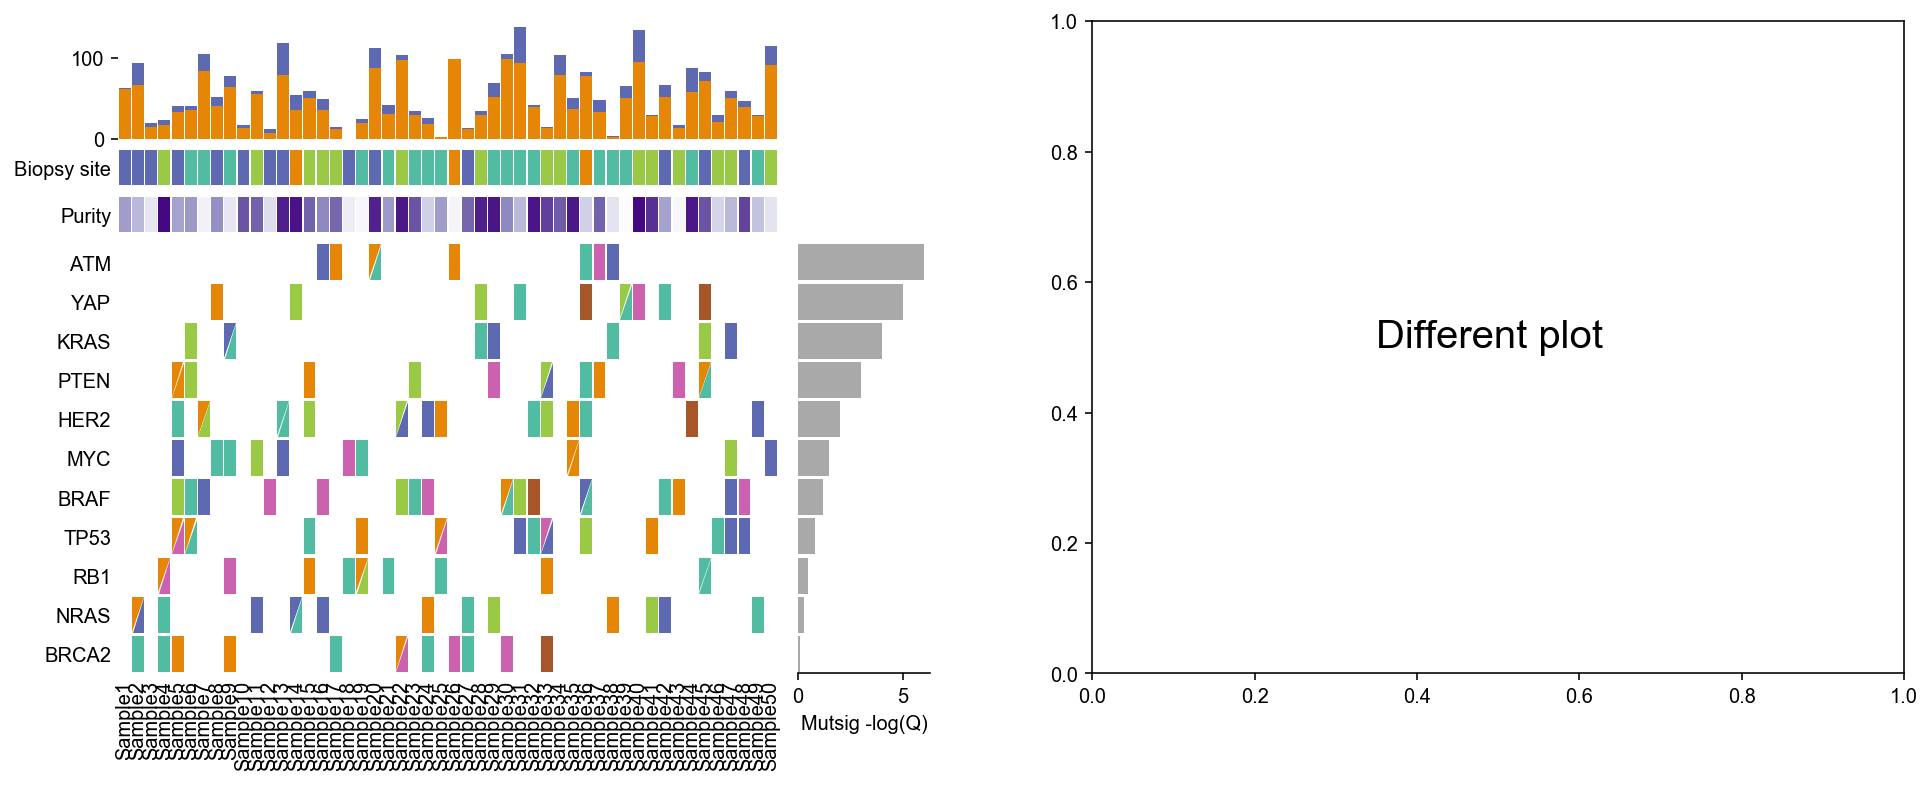

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 6), tight_layout=False)
gs = fig.add_gridspec(1, 2)

toy_comut.plot_comut(x_padding = 0.05, y_padding = 0.04, tri_padding = 0.03, hspace = 0.05, wspace = 0.05,
                     fig = fig, spec = gs[0])

ax = fig.add_subplot(gs[1])
ax.text(0.35, 0.5, s = 'Different plot', size = 20)

<a id="legends"></a>
# 5 Adding a Legend

There are two ways that a legend can be added - `comut.add_unified_legend` and `comut.add_axis_legend`. The former will create one legend that will be placed as one column, while the latter provides more flexibility but requires manual placement.

<a id="unified_legend"></a>
## 5.1 `add_unified_legend`

`add_unified_legend` is a quick solution to place one legend in the comut. It takes legend subtitles from plot names.

__Arguments__:
   * `axis_name`: The axis name on which the unified legend should be added. Defaults to the top plot of the comut plot. If a right side plot exists, this default placement may be insufficient, and axis_name should the right side plot's name.
   * `border_white`: One can pass a list of values that should be drawn as white patches with a black border. Useful for labelling Absent (white) comut values.
   * `headers`: boolean for if subtitles should be included (default `True`). Subtitles are left aligned.
   * `rename`: A dictionary for renaming values. The old category name should be the dictionary keys and the new category name the values. Renaming occurs after `border_white` is applied.
   * `bbox_to_anchor`: argument for specifying where the legend should be located as a tuple. Defaults to (1,1)
   * `ignored_values`: a list of values to ignore when creating the legend. By default, `Absent` and `Not Available` are ignored. 
   * `frameon`: a boolean for whether the legend should have a frame. Default `False`
   * `legend_kwargs`: other kwargs to pass to `ax.legend`, which can be found [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.legend.html)
   
__Example__:


In [23]:
# import all data
mut_df = pd.read_csv('tutorial_data/tutorial_mutation_data.tsv', sep = '\t')
purity_df = pd.read_csv('tutorial_data/tutorial_purity.tsv', sep = '\t')
biopsy_df = pd.read_csv('tutorial_data/tutorial_biopsy_site.tsv', sep = '\t')
mut_burden_df = pd.read_csv('tutorial_data/tutorial_mutation_burden.tsv', sep = '\t')


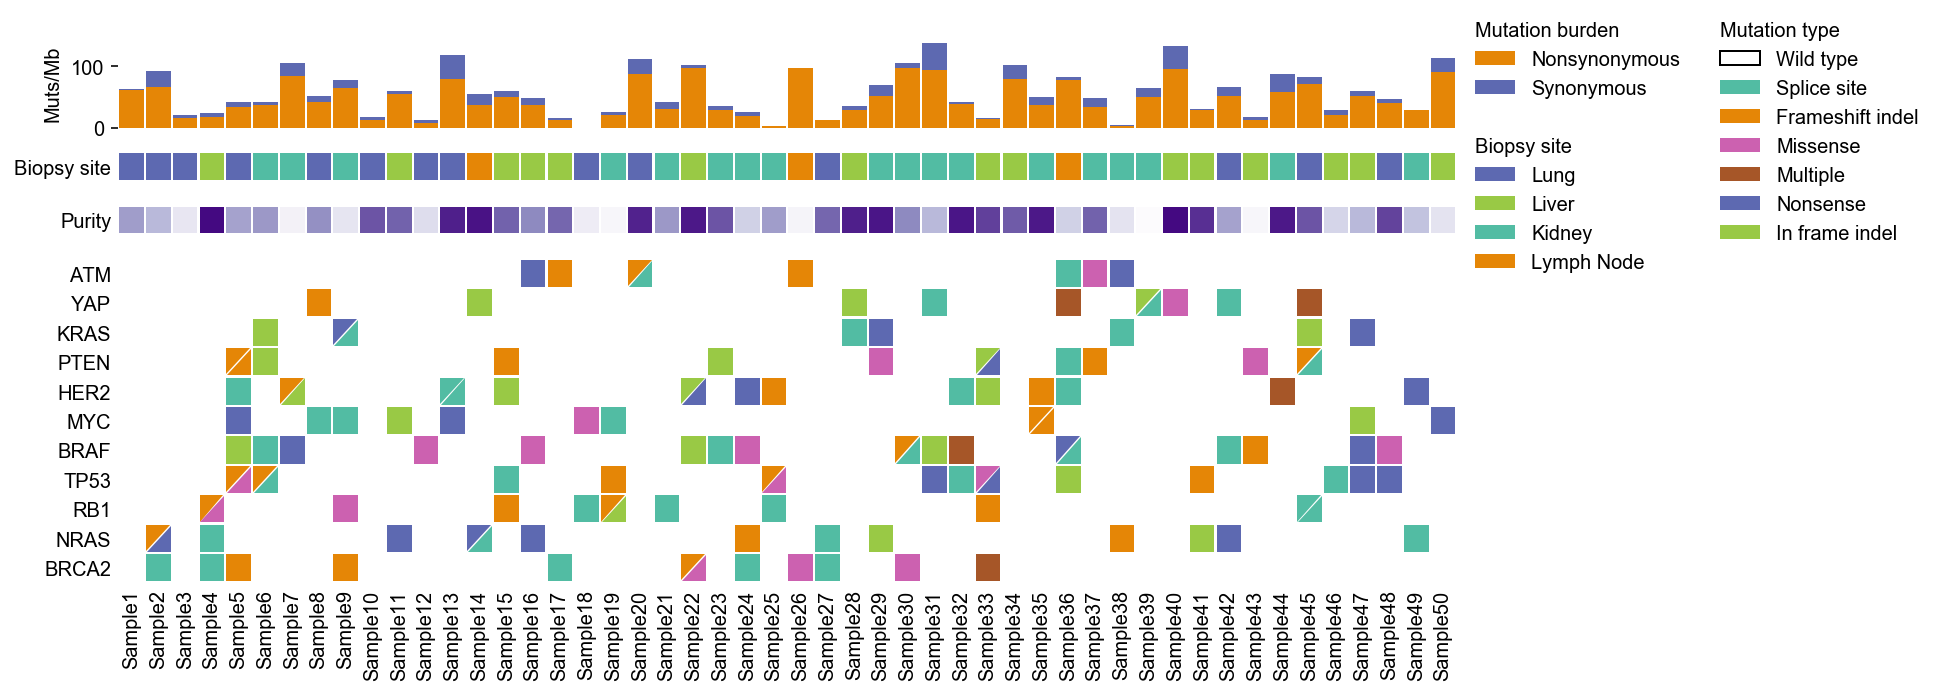

In [24]:
# make CoMut
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]

# add other data
toy_comut.add_categorical_data(cat_data, name = 'Mutation type')
toy_comut.add_continuous_data(purity_data, name = 'Purity', mapping = 'Purples', value_range = (0, 1))
toy_comut.add_categorical_data(biopsy_df, name = 'Biopsy site')
toy_comut.add_bar_data(mut_burden_df, stacked = True, name = 'Mutation burden', ylabel = 'Muts/Mb')

# plot comut
toy_comut.plot_comut(figsize = (12, 5), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03)

# by default, Absent is ignored. We'll introduce it back and rename to "Wild type"
ignored_values = []
border_white = ['Absent']
rename = {'Absent': 'Wild type'}

toy_comut.add_unified_legend(bbox_to_anchor = (1, 1.4), ignored_values = ignored_values, rename = rename,
                             border_white = border_white, ncol = 2)


<a id="axis_legend"></a>
## 5.2 `add_axis_legend`

While `add_unified_legend` creates one legend, `add_axis_legend` creates one legend on an axis, allowing greater control.

__Arguments__
* `name`: Name of axis on which to create the legend
* `border_white`: A list of values that should be drawn as white patches with a black border.
* `rename`: A dictionary that allows for renaming. The old category name should be the key, and the new category name the value. Renaming occurs before `border_white` is applied.
* `order`: Order of values in the legend, as a list. Values not in this list will be placed after those in the list, sorted alphabetically.
* `ignored_values`: List of values that should be ignored when making the legend. Defaults to `['Not Available', 'Absent']`
* `title_align`: The alignment of the legend title in the legend. If no title is specified, nothing happens. Valid values are right, left, and center. Defaults to left.
* `frameon`: a boolean for whether the legend should have a frame. Default `False`
* `bbox_to_anchor`: where the legend should be located as a tuple. Defaults to (1,1)
* `legend_kwargs`: other kwargs to pass to `ax.legend`, which can be found [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.legend.html). One important one is `title`.

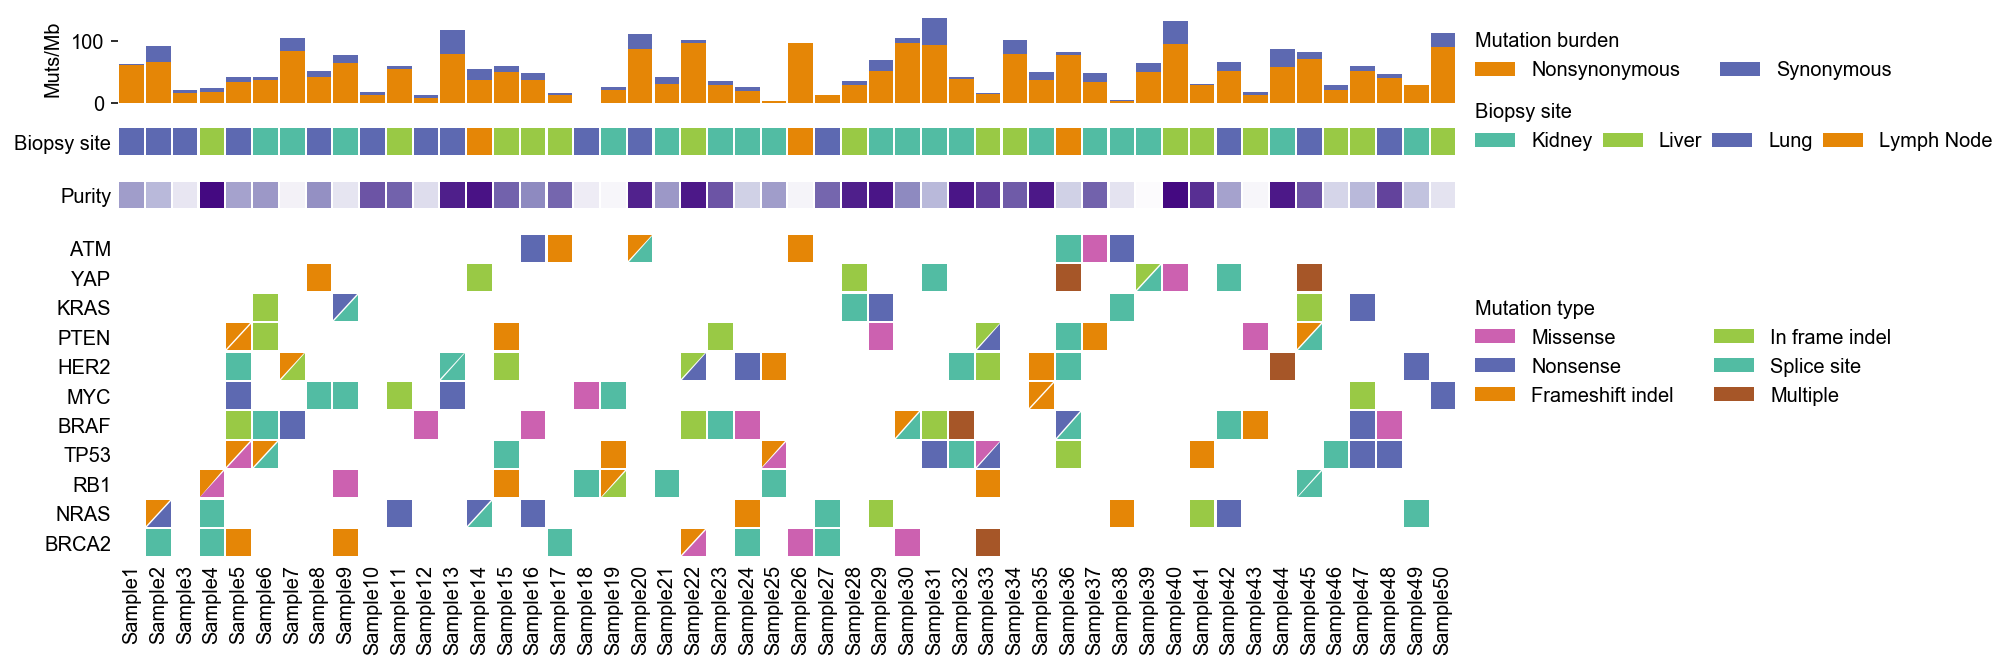

In [25]:
# remove unified legend
if toy_comut.axes['Mutation type'].get_legend() is not None:
    toy_comut.axes['Mutation type'].get_legend().remove()

# set order of mutation legend
mut_order = ['Missense', 'Nonsense', 'Frameshift indel', 'In frame indel', 'Splice site', 'Multiple']
# the add_axis_legend returns a legend that can be edited later
mut_burden_leg = toy_comut.add_axis_legend(name = 'Mutation burden', bbox_to_anchor = (1, 1), title = 'Mutation burden', ncol = 2)
biopsy_leg = toy_comut.add_axis_legend(name = 'Biopsy site', bbox_to_anchor = (1, 2.4), title = 'Biopsy site', ncol = 4, columnspacing = 0.5)
mut_leg = toy_comut.add_axis_legend(name = 'Mutation type', bbox_to_anchor = (1, 0.85), title = 'Mutation type', order = mut_order, ncol = 2)

toy_comut.figure


<a id="comut_appearance"></a>
# 6. Improving comut appearance

<a id="rc_params"></a>
## 6.1 Altering Global Matplotlib Params

Because CoMut uses matplotlib to plot, one can use matplotlib [rcParams](https://matplotlib.org/tutorials/introductory/customizing.html) to change the appearance of the comut. Generally, this is limited to changing fonts and axes labels. Because these are global parameters, they only need to be set once.

__Example:__

In [26]:
from matplotlib import rcParams
custom_rcParams = {'font.family': 'Times New Roman',
                   'font.size': 16}

# update rcParams
rcParams.update(custom_rcParams)

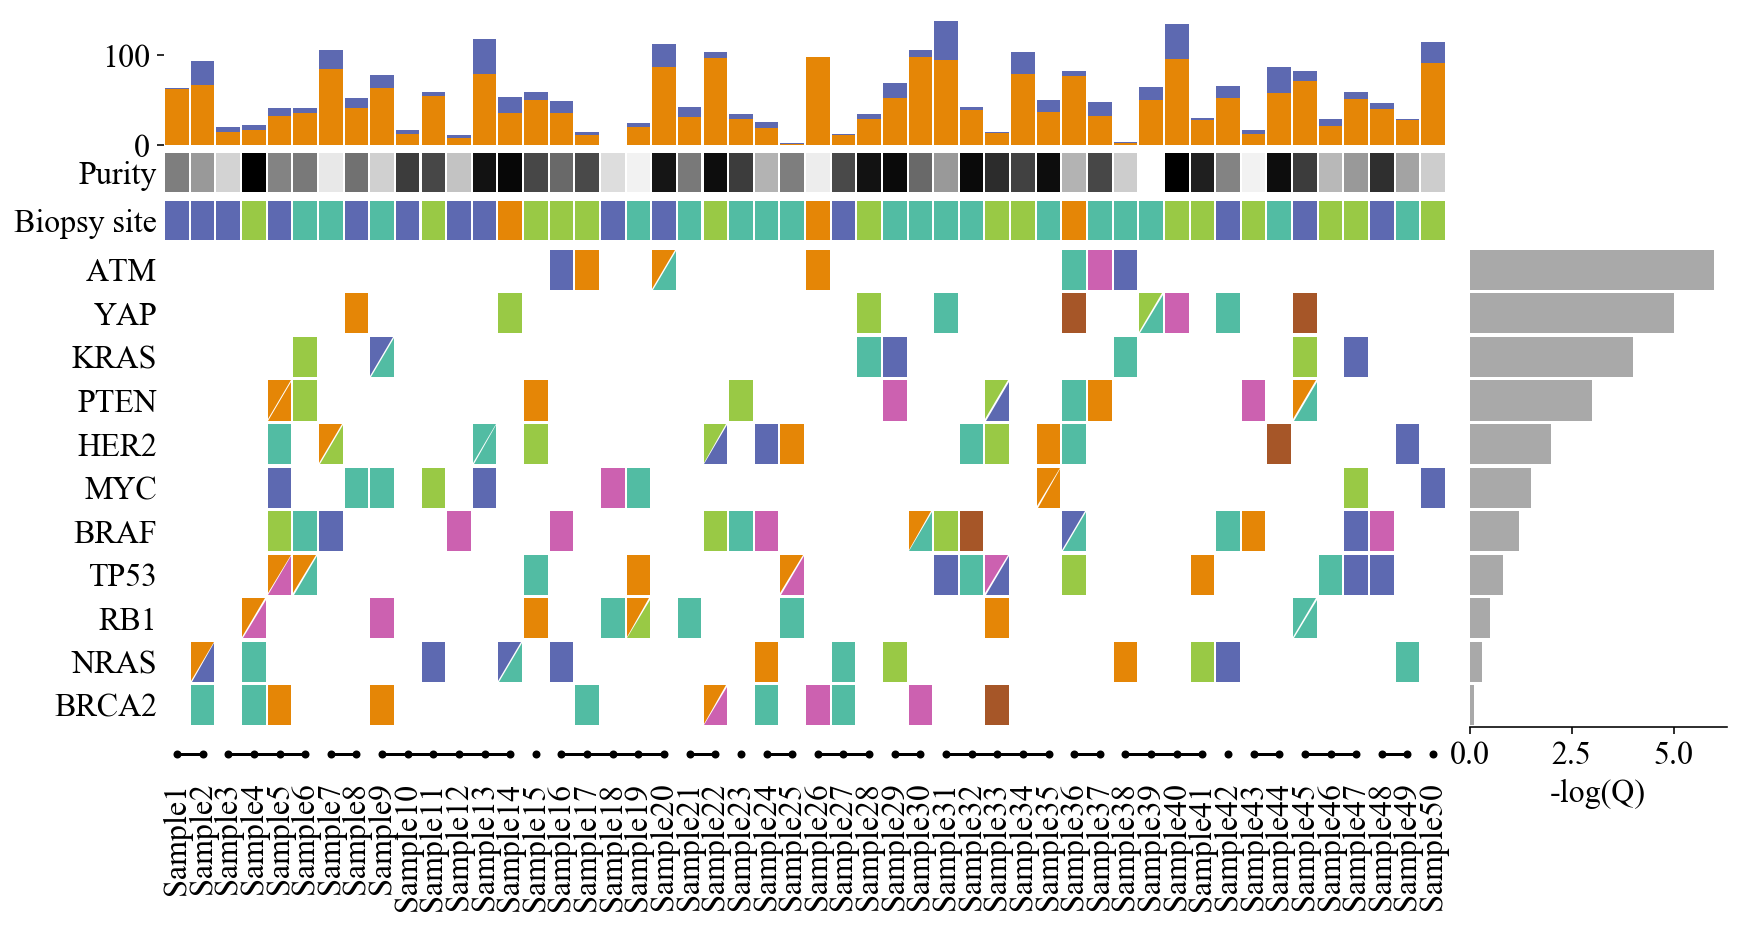

In [27]:
# make CoMut
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]

toy_comut.add_sample_indicators(indicator_df, name = 'Same patient')
toy_comut.add_categorical_data(mut_df, name = 'Mutation type')
toy_comut.add_categorical_data(biopsy_df, name = 'Biopsy site')
toy_comut.add_continuous_data(purity_df, name = 'Purity')
toy_comut.add_bar_data(mut_burden_df, stacked = True, name = 'Mutation burden')
toy_comut.add_side_bar_data(mutsig_df, paired_name = 'Mutation type', name = 'MutsigQ', mapping =  {'-log(Q)': 'darkgrey'}, xlabel = '-log(Q)')

toy_comut.plot_comut(figsize = (14, 7), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, wspace = 0.03, hspace = 0.03)

# update font back to arial
custom_rcParams = {'font.family': 'arial', 'font.size': 12}
rcParams.update(custom_rcParams)


<a id="edit_axes"></a>
## 6.2 Editing Individual Axes

By far the best way to achieve maximal customization for your comut is to edit individual axes objects. On the comut above, we may want to achieve the following:

1. Rotate the mutation burden y label to be horizontal
2. Add a vertical line on -log(Q) = 1 for the mutsig and label those that are significant (-log(Q) > 1)
3. Say we know the following mutations are hotspots: `MYC` in Sample18, `BRAF` in Sample24, and `PTEN` in Sample29. We'd like to indicate these with a star.
4. Remove the sample labels

All of these things can be handled by editing the axes individually. `comut.plot_comut` updates the `comut.axes` attribute of the CoMut object to contain the axis objects. To view the figure after editing the axis, you can use `comut.figure`

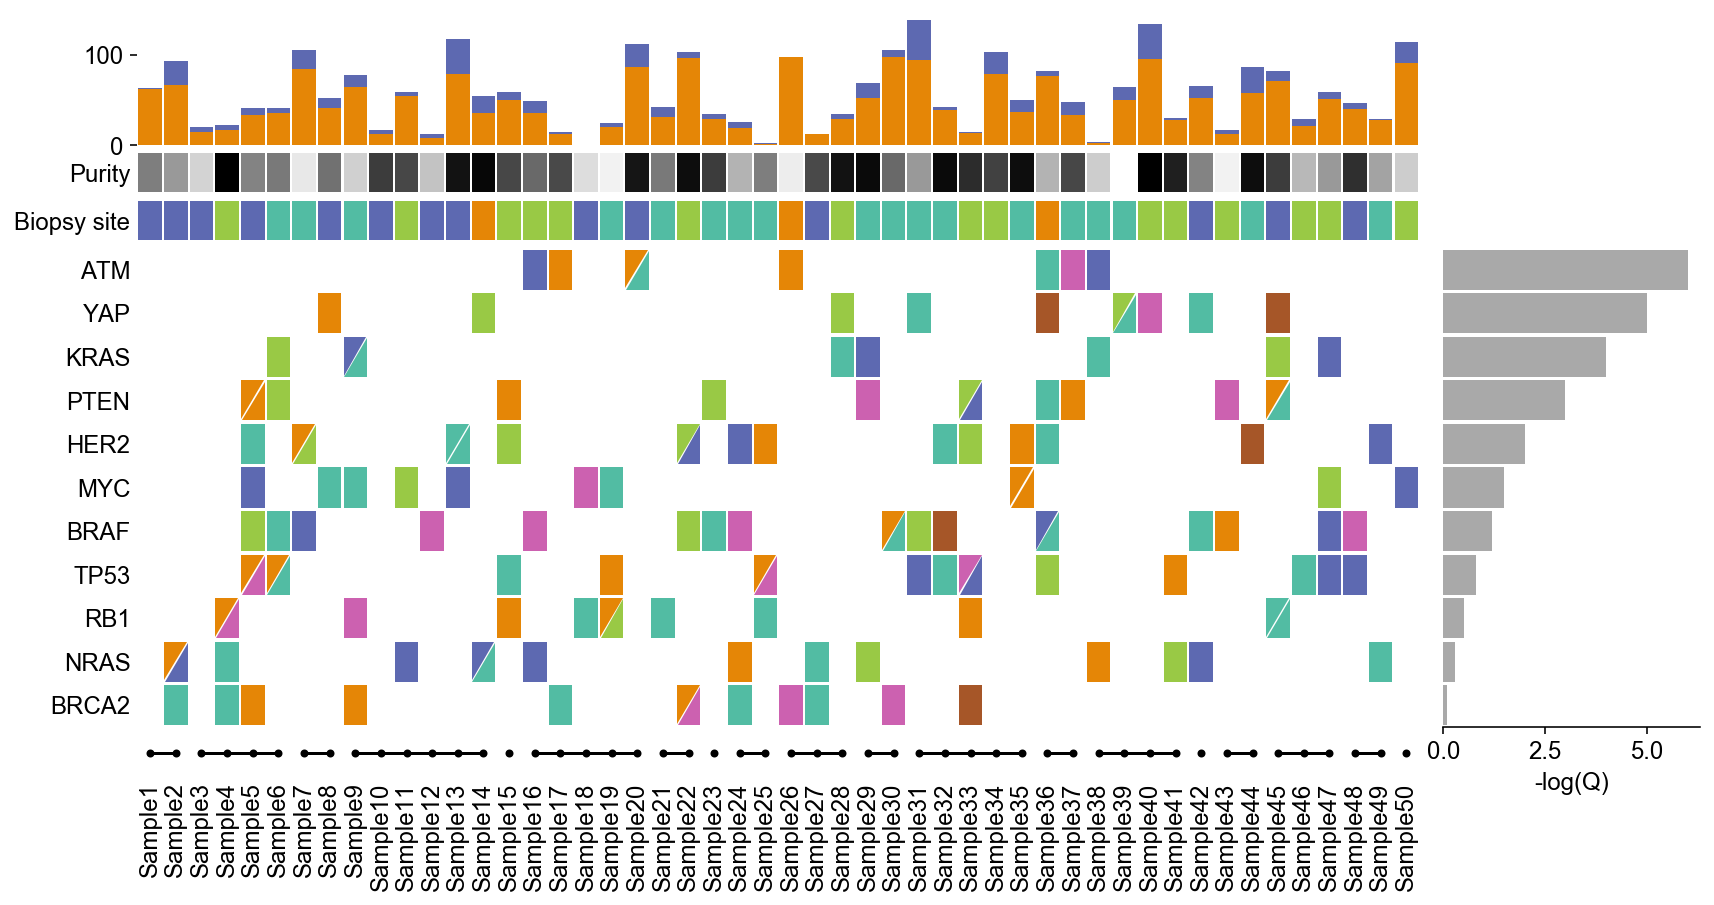

In [28]:
toy_comut = comut.CoMut()
toy_comut.samples = ['Sample' + str(i) for i in range(1,51)]

toy_comut.add_sample_indicators(indicator_df, name = 'Same patient')
toy_comut.add_categorical_data(mut_df, name = 'Mutation type')
toy_comut.add_categorical_data(biopsy_df, name = 'Biopsy site')
toy_comut.add_continuous_data(purity_df, name = 'Purity')
toy_comut.add_bar_data(mut_burden_df, stacked = True, name = 'Mutation burden')
toy_comut.add_side_bar_data(mutsig_df, paired_name = 'Mutation type', name = 'MutsigQ', mapping =  {'-log(Q)': 'darkgrey'}, xlabel = '-log(Q)')

toy_comut.plot_comut(figsize = (14, 7), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, wspace = 0.03, hspace = 0.03)

Here are the axes objects after the comut has been plotted. To access any of them, simply index into the dictionary. This is where the __name__ parameter of `add_xxx_data` becomes important - the keys in the axes dictionary are the names of the plots.

In [29]:
toy_comut.axes

{'Same patient': <matplotlib.axes._subplots.AxesSubplot at 0x1243304e0>,
 'Mutation type': <matplotlib.axes._subplots.AxesSubplot at 0x124fd6b70>,
 'MutsigQ': <matplotlib.axes._subplots.AxesSubplot at 0x124ff2048>,
 'Biopsy site': <matplotlib.axes._subplots.AxesSubplot at 0x125c27be0>,
 'Purity': <matplotlib.axes._subplots.AxesSubplot at 0x125c8e978>,
 'Mutation burden': <matplotlib.axes._subplots.AxesSubplot at 0x125d51470>}

Any function that can operate on an axis object can act on an axis in the CoMut object. For a full list of axis associated methods, see [here](https://matplotlib.org/1.3.1/api/axes_api.html) (though googling is probably your best bet).

[]

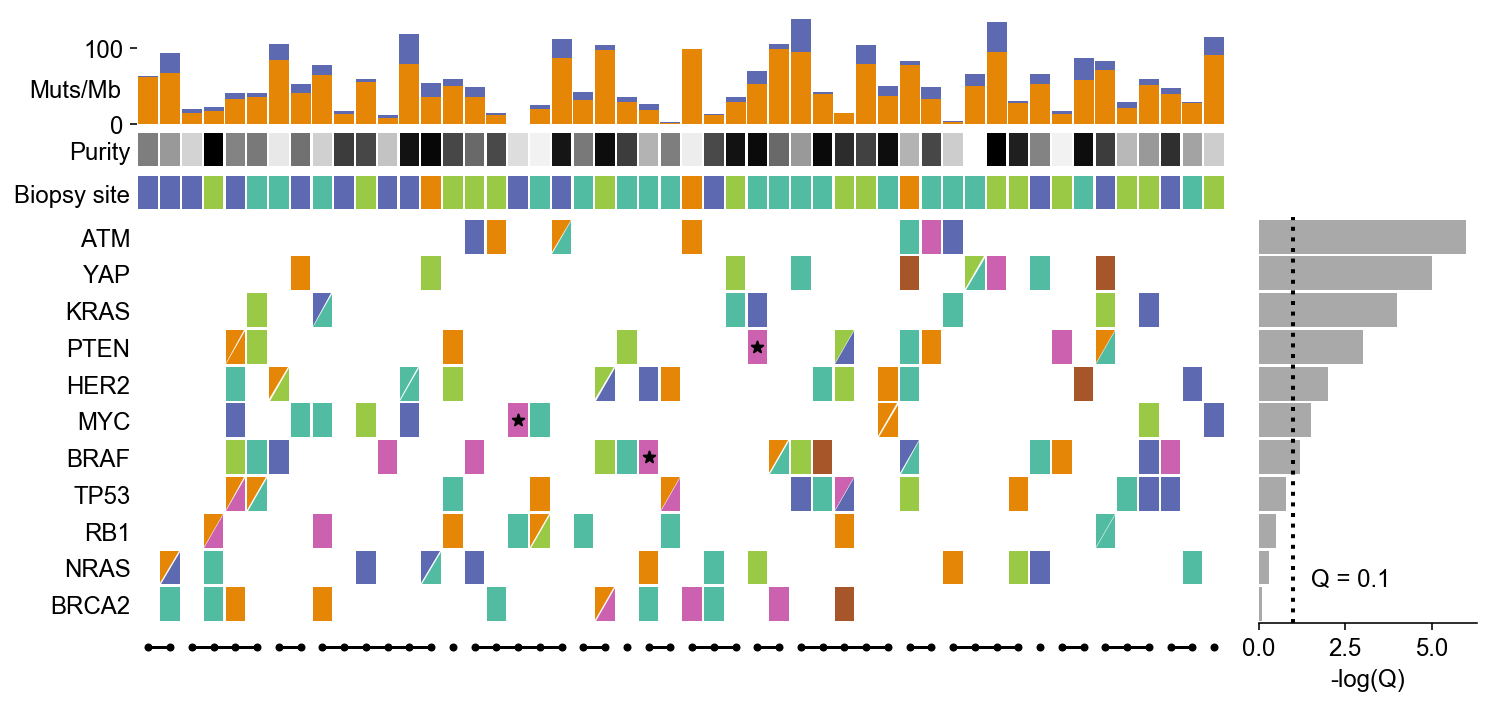

In [30]:
# plot comut
toy_comut.plot_comut(x_padding = 0.05, y_padding = 0.04, tri_padding = 0.03, hspace = 0.05, wspace = 0.05, figsize = (12,6))

# access the mutation part of the CoMut and rotate the y label
toy_comut.axes['Mutation burden'].set_ylabel('Muts/Mb', rotation = 'horizontal', 
                                             ha = 'center', va = 'center', y = 0.3)

# add a vertical line at -log(Q) = 1 and a text box to the mutsig side bar plot
toy_comut.axes['MutsigQ'].axvline(1, color = 'black', linestyle = 'dotted', linewidth = 2)
toy_comut.axes['MutsigQ'].annotate(s = 'Q = 0.1', xy = (1.5, 1.0))

# add stars to hotspot mutations
gene_locs = [4, 5, 7]
sample_locs = [23, 17, 28]
for i in range(3):
    gene_loc, sample_loc = gene_locs[i], sample_locs[i]
    toy_comut.axes['Mutation type'].scatter(x = [sample_loc + 0.5], y = [gene_loc + 0.5], marker = '*', color = 'black', zorder = 2)

# remove sample labels - they always exist attached to the bottom plot
toy_comut.axes['Same patient'].set_xticklabels([])

<a id="export"></a>
# 7. Exporting the comut

After creating the comut, the figure can be saved using `comut.figure.savefig`. You will likely either using the `.png`, `.jpg`, `.svg`, or `.pdf` file formats. `.svg` or `.pdf` are usually preferrable because they infinitely scaleable (meaning that as you zoom into the figure, resolution does not decrease). If `.png`/`.jpg` is required, you can set the resolution on export using `dpi`. `bbox_inches = 'tight'` means the image is cropped to just the comut.

In [31]:
toy_comut.figure.savefig('images/tutorial_comut.svg', bbox_inches = 'tight', dpi = 300)

<a id="pandas_help"></a>
# 8. What to do if you're unfamiliar with pandas

Some level of pandas familiarity is useful for using this package. If you're not savvy with pandas, pandas can read in `.tsv` and `.csv` files with `pd.read_csv(file_path)` (with the argument `sep = '\t'` for `.tsv` files). So, for example, you can subset your maf to the mutations you want to plot using your software of choice (R, excel, etc), save it as a tsv/csv file, then read it in with `pd.read_csv(path)`. All of the data read in for this tutorial is in the form of `.tsv` files in `tutorial_data`, with minimal pandas manipulation. Just be sure to follow what CoMut expects for the various data types.

You can also refer to [quickstart](https://github.com/vanallenlab/comut/blob/master/quickstart.ipynb), which is a notebook that contains easily editable code that you can replace with your own file paths to make basic comuts.

<a id="example"></a>
# 9. Example of comut with data from Liu et al. 2019

In this section, we'll produce the comut that is provided in CoMut's manuscript. The data was taken from [Liu, D., Schilling, B., Liu, D. et al. Integrative molecular and clinical modeling of clinical outcomes to PD1 blockade in patients with metastatic melanoma. Nat Med 25, 1916–1927 (2019). https://doi.org/10.1038/s41591-019-0654-5](https://www.nature.com/articles/s41591-019-0654-5) and formatted into the form CoMut expects.

## Import and format data

In [32]:
# import maf and reformat/rename to match what CoMut expects
mutation_df = pd.read_csv('tutorial_data/melanoma_example/melanoma.maf', sep = '\t')
variant_col_df = fileparsers.parse_maf(mutation_df)

# import copy number data
copy_number_df = pd.read_csv('tutorial_data/melanoma_example/copy_number_alterations.tsv', sep = '\t')

# whole genome doubling data
wgd_df = pd.read_csv('tutorial_data/melanoma_example/whole_genome_doubling.tsv', sep = '\t')

# purity data
purity_df = pd.read_csv('tutorial_data/melanoma_example/purity.tsv', sep = '\t')

# response data
best_response_df = pd.read_csv('tutorial_data/melanoma_example/best_response.tsv', sep = '\t')

# primary type data
primary_type_df = pd.read_csv('tutorial_data/melanoma_example/primary_type.tsv', sep = '\t')

# mutational signature data
mut_sig_df = pd.read_csv('tutorial_data/melanoma_example/mutation_signatures.tsv', sep = '\t')

# create mutation burden dataframe
mut_burden_df = pd.read_csv('tutorial_data/melanoma_example/mutational_burden.tsv', sep = '\t')

# calculate side bar data from mutation data
mut_freqs = pd.read_csv('tutorial_data/melanoma_example/mutation_frequency.tsv', sep = '\t')

In [33]:
# create toy indicator data
np.random.seed(2)
indicators = sorted(np.random.choice(range(30), size = 52))
indicator_df = mut_burden_df[['sample']].copy()
indicator_df['group'] = indicators
indicator_df.head()

,sample,group
0,Patient41,1
1,Patient62,2
2,Patient49,2
3,Patient51,3
4,Patient99,3


<a id="mel_order"></a>
## Determine patient order

Order first by response category, then by total mutation burden

In [34]:
# calculate total burden
clinical_data = pd.read_csv('tutorial_data/melanoma_example/merged_clinical_data.tsv', sep = '\t')
clinical_data['total_burden'] = clinical_data['clonal_muts'] + clinical_data['subclonal_muts']

# classify best response - CR and PR first, then PD, then MR and SD (from left to right in comut)
resp_idx_mapping = {'CR': 2, 'PR': 2, 'PD':1, 'MR': 0, 'SD': 0}
clinical_data['resp_idx'] = clinical_data['BR'].apply(lambda x: resp_idx_mapping[x])

# order first by best response, then by total burden
clinical_data = clinical_data.sort_values(by = ['resp_idx', 'total_burden'], ascending = [False, False])

# the resulting sample column is our sample order
sample_order = list(clinical_data['sample'])

<a id="mel_mapping"></a>
## Define mappings and `add_xxx_data` arguments

In [35]:
balance_6 = palettable.cmocean.diverging.Balance_6.mpl_colors
safe_10 = palettable.cartocolors.qualitative.Safe_10.mpl_colors
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
purp_7 = palettable.cartocolors.sequential.Purp_7.mpl_colormap

indicator_kwargs = {'color': 'black', 'marker': 'o', 'linewidth': 1, 'markersize': 5}

wgd_mapping = {'Yes': {'facecolor': 'black', 'alpha': 0.5}, 'No': 'white'}

cna_mapping = {'Baseline': 'white', 'Allelic amplification': balance_6[-2], 'Allelic deletion': balance_6[1],
               'aCN = 0': {'facecolor': 'black', 'alpha': 0.5}, 'CN-LOH': vivid_10[8], 'Complex': vivid_10[2]}
cna_order = ['CDKN2A', 'TP53', 'MYC']

mut_order = ['CDKN2A', 'TP53', 'NF1', 'NRAS', 'BRAF']
mut_mapping = {'Missense': vivid_10[5], 'Nonsense': vivid_10[0], 'In frame indel': vivid_10[1],
               'Frameshift indel': vivid_10[4], 'Splice site': vivid_10[-1]}

purity_mapping = purp_7

primary_type_mapping = {'Skin':safe_10[2], 'Acral': vivid_10[2], 'Occult': vivid_10[-1], 'Mucosal': vivid_10[4]}

response_mapping = {'SD': balance_6[1], 'MR':  vivid_10[8], 'PR': vivid_10[5], 'CR': vivid_10[3], 'PD':  vivid_10[0]}

sig_bar_kwargs = {'edgecolor': 'white', 'width': 0.96, 'linewidth': 0.5}
sig_mapping = {'UV': purp_7(0.2), 'Alkylating': vivid_10[8], 'Aging+':safe_10[2]}

burden_mapping = {'Clonal':vivid_10[8], 'Subclonal':purp_7(0.5)}

side_bar_kwargs = {'alpha': 0.5}
side_mapping = {'Mutated samples': 'darkgrey'}

<a id="mel_add"></a>
## Add data to comut

In [36]:
melanoma_comut = comut.CoMut()

# define order of comut BEFORE any data is added
melanoma_comut.samples = sample_order

# add sample indicators
melanoma_comut.add_sample_indicators(indicator_df, name = 'Same patient', plot_kwargs = indicator_kwargs)

# add wgd, copy number, mutations, purity, primary type, best response, mutational signatures, and mutation burden
melanoma_comut.add_categorical_data(wgd_df, name='WGD', mapping = wgd_mapping)

melanoma_comut.add_categorical_data(copy_number_df, name='Copy number alteration', mapping = cna_mapping,
                                    category_order = cna_order, tick_style='italic')

melanoma_comut.add_categorical_data(variant_col_df, name = 'Mutation type', category_order = mut_order,
                                    mapping = mut_mapping, tick_style = 'italic')

melanoma_comut.add_continuous_data(purity_df, name = 'Purity',  mapping = purp_7, value_range = (0, 1))

melanoma_comut.add_categorical_data(primary_type_df, name='Primary type', mapping = primary_type_mapping)

melanoma_comut.add_categorical_data(best_response_df, name='Best response', mapping = response_mapping)

melanoma_comut.add_bar_data(mut_sig_df, name = 'Mutational signatures', mapping = sig_mapping, stacked = True, ylabel = 'Mutational\nsignatures',
                            bar_kwargs = {'edgecolor': 'white', 'width': 0.96, 'linewidth': 0.5})

melanoma_comut.add_bar_data(mut_burden_df, name = 'Mutation clonality', mapping = burden_mapping, stacked = True, 
                            ylabel = 'Nonsyn.\nMutations')

melanoma_comut.add_side_bar_data(mut_freqs, paired_name = 'Mutation type', name = 'Mutated samples', position = 'left', 
                                 mapping = side_mapping, xlabel = 'Mutated samples', bar_kwargs = {'alpha': 0.5})

## Plot comut and edit appearance

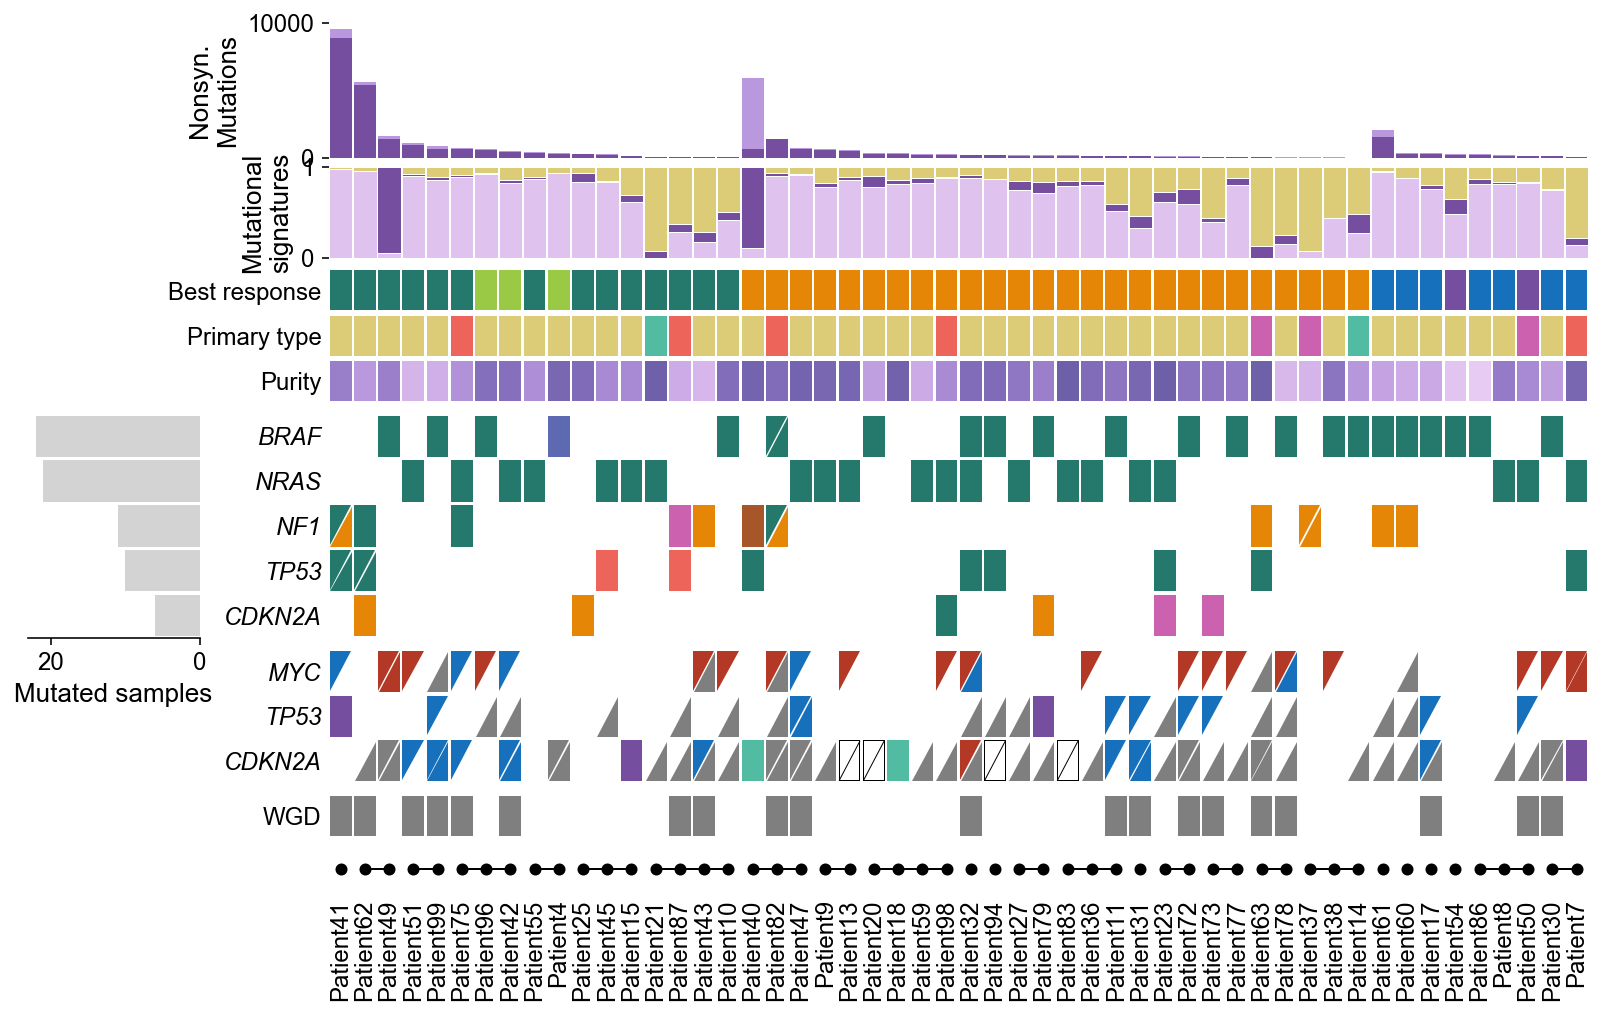

In [37]:
# global matplotlib params
custom_rcParams = {
    'font.family': 'Arial',
    'font.size': 12,
    'axes.labelsize': 13,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
}

rcParams.update(custom_rcParams)

# define structure
structure = [['Same patient'],
             ['WGD'],
             ['Copy number alteration'], 
             ['Mutation type'], 
             ['Purity', 'Primary type', 'Best response'], 
             ['Mutational signatures'], 
             ['Mutation clonality']]

#default for bar plots is 3, decrease mutational signatures to 2
heights = {'Mutational signatures': 2}

# decrease size of side bar
widths = [0.6, 4.4]

# move side bar plot slightly closer to comut
wspace = 0.18

# plot the comut
melanoma_comut.plot_comut(x_padding = 0.05, y_padding = 0.04, tri_padding = 0.03, hspace = 0.08, structure = structure, subplot_hspace = 0.01,
                          heights = heights, widths = widths, wspace = wspace, figsize = (14, 8))

<a id="mel_axes"></a>
## Edit individual axes

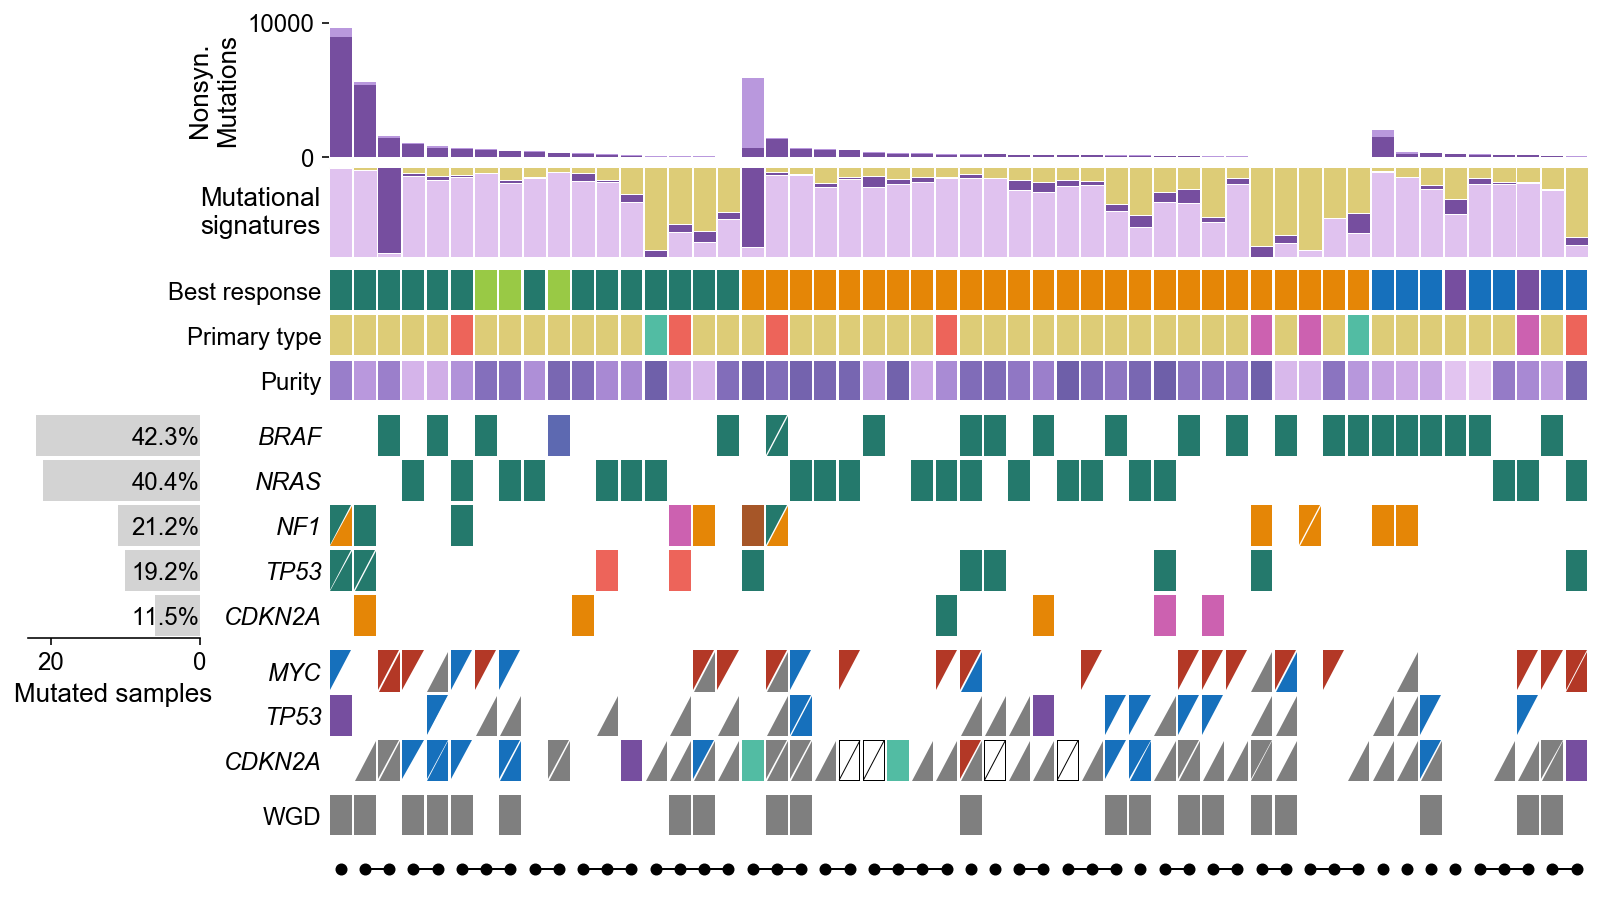

In [38]:
# the sample labels are always added to the bottom plot in the comut - remove them.
melanoma_comut.axes['WGD'].set_xticklabels([])

# delete the ytick labels for the mutational signature plot. It's implied the scale is 0 - 1. Also add a ylabel
melanoma_comut.axes['Mutational signatures'].tick_params(axis = 'y', which='both', length=0, labelleft=False)
melanoma_comut.axes['Mutational signatures'].set_ylabel('Mutational\nsignatures', rotation = 'horizontal', 
                                                        ha = 'right', va = 'center')

# make it so that there is no annoying scientific notation for the y axis of the burden plot
melanoma_comut.axes['Mutation clonality'].ticklabel_format(axis='y', style='plain')
melanoma_comut.figure

# calculate the percentage of samples with that gene mutated, rounding and adding a percent sign
percentages = (mut_freqs['Mutated samples']/len(sample_order)*100).round(1).astype(str) + '%'

# set location of yticks
melanoma_comut.axes['Mutated samples'].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])

# set labels of yticks
melanoma_comut.axes['Mutated samples'].set_yticklabels(list(percentages[::-1]))

# move the ytick labels inside the bar graph
melanoma_comut.axes['Mutated samples'].tick_params(axis='y', pad=-34)

# Make y axis visible (by default it is not visible)
melanoma_comut.axes['Mutated samples'].get_yaxis().set_visible(True)

# move y axis ticks to the right
melanoma_comut.axes['Mutated samples'].yaxis.tick_right()

melanoma_comut.figure

## Add a legend

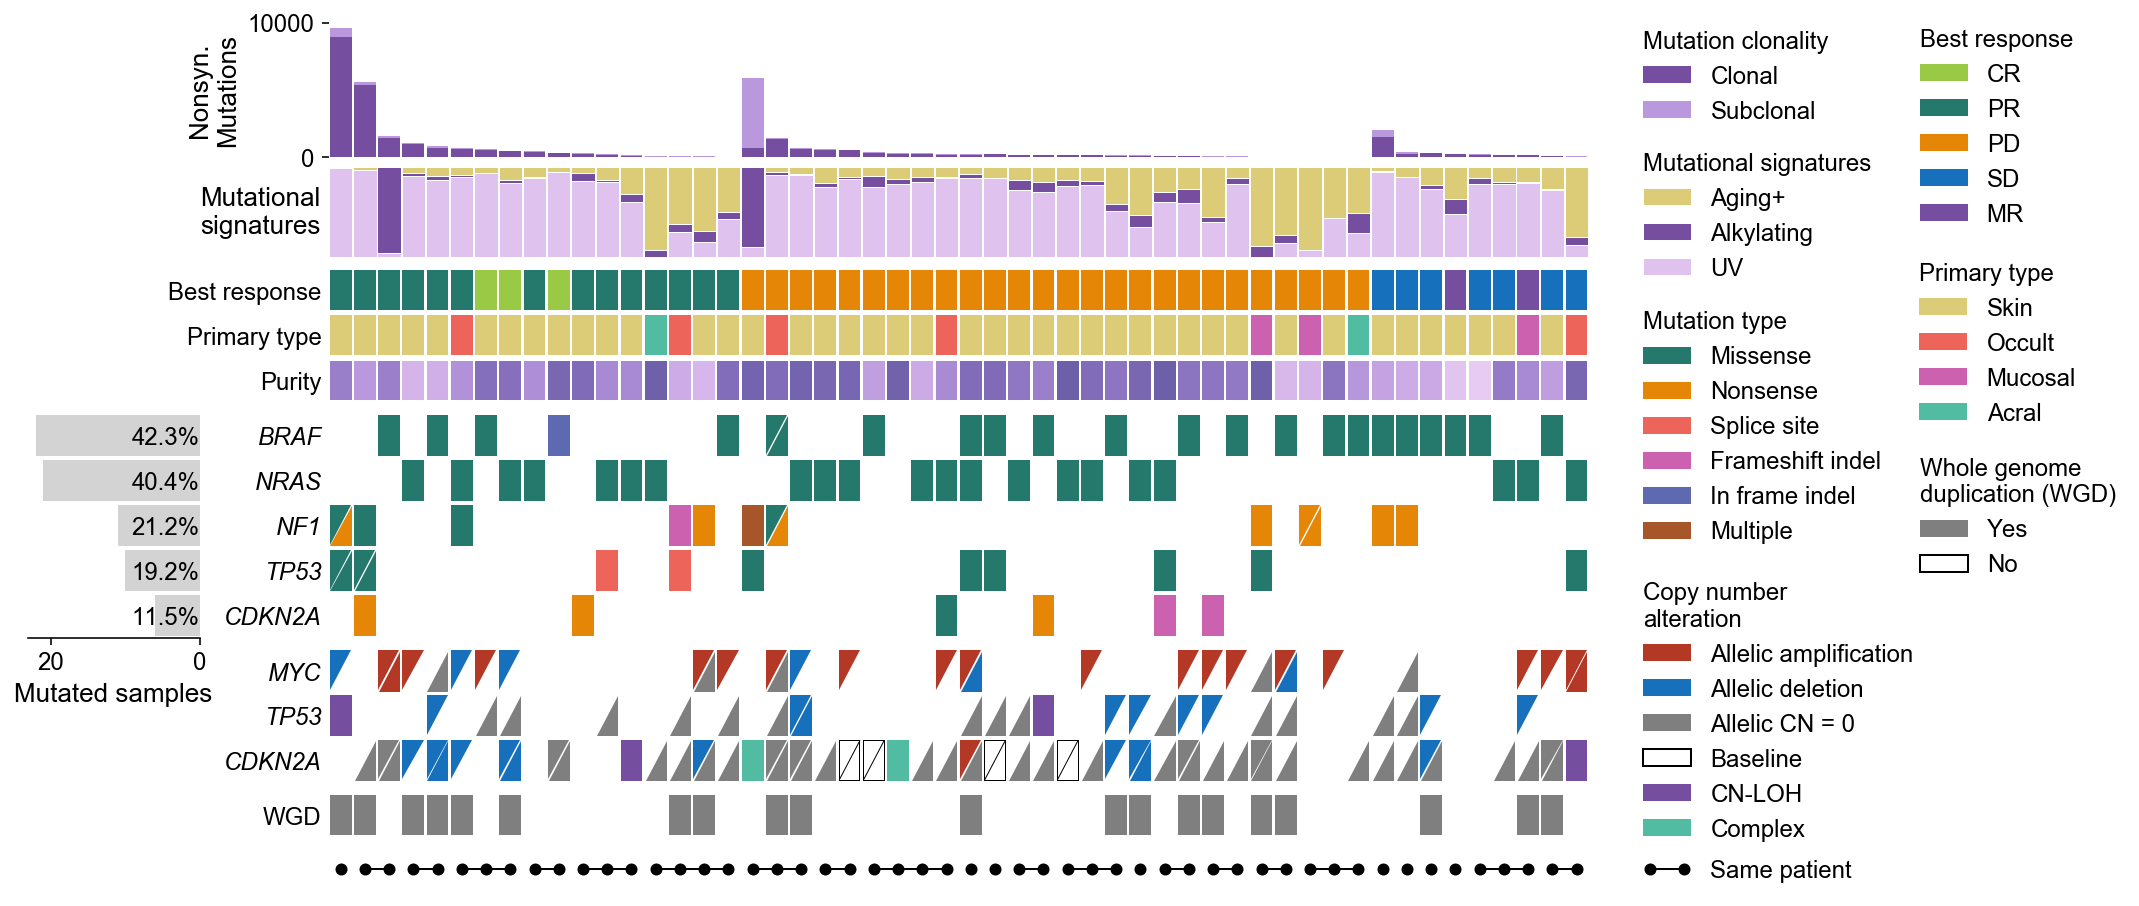

In [40]:
# make a legend for each axis
mut_clon_leg = melanoma_comut.add_axis_legend('Mutation clonality', bbox_to_anchor = (1.2065 ,1.1), frameon = False, title = 'Mutation clonality')
mut_sig_leg = melanoma_comut.add_axis_legend('Mutational signatures', bbox_to_anchor = (1.025,1.4), frameon = False, title = 'Mutational signatures')

# set order for primary type
primary_leg_order = ['Skin', 'Occult', 'Mucosal', 'Acral']
primary_leg = melanoma_comut.add_axis_legend('Primary type', bbox_to_anchor = (1.4025, 2.59), frameon = False,
                                             title = 'Primary type', order = primary_leg_order)

# set order for response legend
resp_order = ['CR', 'PR', 'PD', 'SD', 'MR']
response_leg = melanoma_comut.add_axis_legend('Best response', bbox_to_anchor = (1.40, 6.79), frameon = False, order = resp_order,
                                              title = 'Best response')

# set order for mutation legend
mut_leg_order = ['Missense', 'Nonsense', 'Splice site', 'Frameshift indel', 'In frame indel']
mut_leg = melanoma_comut.add_axis_legend('Mutation type', bbox_to_anchor = (1.025, 1.542), frameon = False, 
                                         title = 'Mutation type', order = mut_leg_order)

# set order for cna legend
cna_leg_order = ['Allelic amplification', 'Allelic deletion', 'Allelic CN = 0', 'Baseline', 'CN-LOH', 'Complex']
cna_leg = melanoma_comut.add_axis_legend('Copy number alteration', bbox_to_anchor = (1.025, 1.64), frameon = False, title = 'Copy number\nalteration',
                                        border_white = ['Baseline'], rename = {'aCN = 0': 'Allelic CN = 0'}, order = cna_leg_order)

# add whole genome doubling legend
wgd_leg = melanoma_comut.add_axis_legend('WGD', bbox_to_anchor = (1.434, 8.88), frameon = False, title = 'Whole genome\nduplication (WGD)',
                                         border_white = ['No'], order = ['Yes', 'No'])

# add indicator legend
wgd_leg = melanoma_comut.add_axis_legend('Same patient', bbox_to_anchor = (1.025, 1.2), frameon = False, numpoints = 2)

melanoma_comut.figure.savefig('images/melanoma_comut.png', bbox_inches = 'tight', dpi = 300)
melanoma_comut.figure

<a id="faq"></a>
# 10. Frequently Asked Questions

__Why is CoMut giving me an ` Unknown samples` error?__

CoMut determines the samples present in the comut based on the first samples added. If you add a dataset that is missing samples (for example, some of your samples aren't present in the first dataframe you add), these samples don't exist to CoMut. You should specify the full list of samples that you want to plot by specifying it *before* data is added. That way, if CoMut doesn't see a sample in a future dataset, it will fill it in with a blank patch (or a 0 height bar, etc). See the part in the melanoma example [where sample order was specified](#mel_add).

__How do I remove the sample labels from the comut?__

Sample labels exist on the bottom-most axis of the comut. Simply remove them by using `comut_name.axes[axis_name].set_xticklabels([])`. See the [section where individual axes are edited](#edit_axes) for an example.

__The unified legend skips continuous data. How do I create a legend entry to show a color bar for continuous data?__

CoMut does not currently support color bars for continuous data. Future releases may support this, but for now you should look into adding a colorbar to the comut figure with [plt.colorbar](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.colorbar.html) and specifying an axis location for the colorbar with `fig.add_axes` as in [this example](https://stackoverflow.com/questions/13310594/positioning-the-colorbar).

__I want to order my samples such that those mutated in the most commonly mutated gene appear to the left. How can I do this with CoMut?__

Currently, you can't. CoMut provides no functionality for ordering samples based on any data properties. You should order the samples yourself, and then set this order __before data is added__ with `comut.samples = sample_order`. See the melanoma example where samples were [sorted](#mel_order) and then where [sample order was specified](#mel_add) before adding data to the CoMut object.
